In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize as sciopt
from numpy import genfromtxt
import scipy.stats as scistat
import scipy.integrate as scint
import pandas as pd
import random as rand
from matplotlib.ticker import ScalarFormatter

# Load & Strength Data Method

## Failure occurs due to operational fatigue, live(material) loads, dead loads, encrustation & digging. And these loads are shown to be normally distributed and decrease in stregth can be an indicator of fatigue development

### Non-degrading component-Reliability

[0.99965179 0.94919361 0.93200425 0.92055758 0.91182206 0.90470125
 0.89866308 0.89340593 0.88874111 0.88454221 0.88072015 0.87720964
 0.87396134 0.87093698 0.86810625 0.86544473 0.86293244 0.86055277
 0.85829183 0.85613782 0.85408066 0.85211163 0.8502232  0.84840875
 0.84666246 0.8449792  0.8433544  0.84178397 0.84026425 0.83879194
 0.83736407 0.83597793 0.83463105 0.8333212  0.83204631 0.83080451
 0.82959406 0.82841335 0.82726091 0.82613538 0.82503547 0.82396002
 0.82290791 0.82187813 0.82086971 0.81988176 0.81891343 0.81796394
 0.81703254 0.81611853 0.81522127 0.81434012 0.81347449 0.81262384
 0.81178764 0.81096539 0.81015662 0.80936088 0.80857774 0.80780681
 0.80704769 0.80630002 0.80556344 0.80483763 0.80412227 0.80341704
 0.80272166 0.80203585 0.80135935 0.80069189 0.80003323 0.79938313
 0.79874138 0.79810774 0.79748202 0.79686402 0.79625353 0.79565038
 0.79505439 0.79446538 0.79388319 0.79330765 0.79273862 0.79217594
 0.79161948 0.79106908 0.79052462 0.78998597 0.789453   0.7889

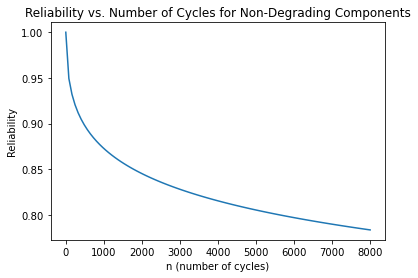

In [2]:
from scipy.integrate import trapz
strength_data=np.random.normal(600*10**6 
                 ,60*10**6 
                 ,(8000,)) 

load_data=np.random.normal(400*10**6 
                 ,40*10**6 
                 ,(8000,)) 

xvals=np.linspace(min(load_data), max(load_data),8000)
xvals1=np.linspace(min(strength_data), max(strength_data),8000)
n_values = np.linspace(0, 8000, 100)
def reliability_nondegrading(n):
    fdelta_delta=scistat.norm.pdf(xvals1,loc=600*10**6, scale=60*10**6)
    Fs_delta=scistat.norm.cdf(xvals1,loc=400*10**6, scale=40*10**6)
    result=fdelta_delta*(Fs_delta)**n
    return result


n_values = np.linspace(0, 8000, 100)


results = []
for n in n_values:
    result = reliability_nondegrading(n)
    results.append(result)
#print(results)    
integration_limit = 300 * 10**9
reliability_nd = scint.trapz(results, xvals1[:np.searchsorted(xvals1, integration_limit)])
print(reliability_nd)


plt.plot(n_values, reliability_nd)
plt.xlabel("n (number of cycles)")
plt.ylabel("Reliability")
plt.title("Reliability vs. Number of Cycles for Non-Degrading Components")
# plt.ylim(0.7,1)
plt.show()     


### Degrading Components-Reliability

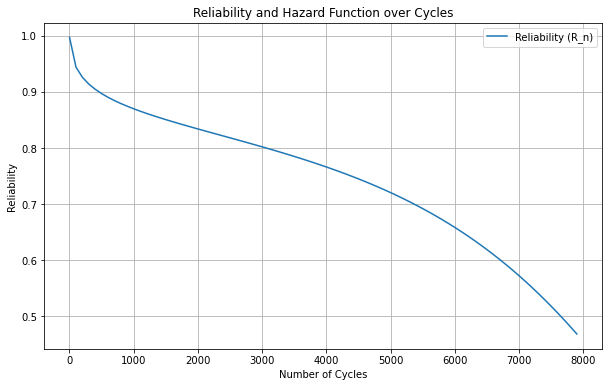

In [3]:
import numpy as np
import scipy.stats as scistat
import scipy.integrate as scint
import matplotlib.pyplot as plt

# Define parameters
strength_o = 600 * 10**6
load = 400 * 10**6
mu_strength = 600 * 10**6
sigma_strength = 60 * 10**6
mu_load = 400 * 10**6
sigma_load = 40 * 10**6
N = 15000
c = 1.5

# Strength degradation function
def strength_degradation(n, strength_original, mean_load, N, c):
    delta_new = []
    for i in range(1, n + 1):
        delta_new.append(strength_original - (strength_original - mean_load) * ((i-1) / N) ** c)
    return delta_new

# PDF of strength
def f_strength(strength, mean, std):
    return scistat.norm.pdf(strength, mean, std)

# CDF of load
def F_s_load(load, mean, std):
    return scistat.norm.cdf(load, mean, std)

# Function for calculating fmultF
def fmultF(strength, n, mean_strength, std_strength, mean_load, std_load, N, c):
    strength_vals_n = strength_degradation(n, strength, mean_load, N, c)
    F_s_list = F_s_load(strength_vals_n, mean_load, std_load)
    F_mult = np.prod(F_s_list)
    return f_strength(strength, mean_strength, std_strength) * F_mult

# Function for calculating fmult1multF
def fmult1multF(strength, n, mean_strength, std_strength, mean_load, std_load, N, c):
    strength_vals_n = strength_degradation(n, strength, mean_load, N, c)
    F_s_list = F_s_load(strength_vals_n, mean_load, std_load)
    F_mult = np.prod(F_s_list)
    return f_strength(strength, mean_strength, std_strength) * (1 - F_s_list[-1]) * F_mult

# Function for calculating R_n_new
def R_n_new(n, mean_strength, std_strength, mean_load, std_load, N, c):
    integral, answer = scint.quad(fmultF, 0, mean_strength + 5 * std_strength, args=(n, mean_strength, std_strength, mean_load, std_load, N, c))
    return integral

# Function for calculating h_n_new
def h_n_new(n, mean_strength, std_strength, mean_load, std_load, N, c):
    integral_top, answer = scint.quad(fmult1multF, 0, mean_strength + 5 * std_strength, args=(n, mean_strength, std_strength, mean_load, std_load, N, c))
    bot_int = R_n_new(n, mean_strength, std_strength, mean_load, std_load, N, c)
    return integral_top / bot_int

# Range of n values
n_vals = np.arange(1, 8000, 100)
# residual_strength_baseline=np.array(strength_degradation(n_vals, strength_o, load, N, c))

# Calculate R_n and h_n for each n
R_n_vals = []
h_n_vals = []
for n in n_vals:
    R_n_vals.append(R_n_new(n, mu_strength, sigma_strength, mu_load, sigma_load, N, c))
    h_n_vals.append(h_n_new(n, mu_strength, sigma_strength, mu_load, sigma_load, N, c))

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(n_vals, R_n_vals, label='Reliability (R_n)')
# plt.plot(n_vals, h_n_vals, label='Hazard Function (h_n)')
plt.xlabel('Number of Cycles')
plt.ylabel('Reliability')
plt.title('Reliability and Hazard Function over Cycles')
plt.legend()
plt.grid(True)
plt.show()


0.0002786654381962255


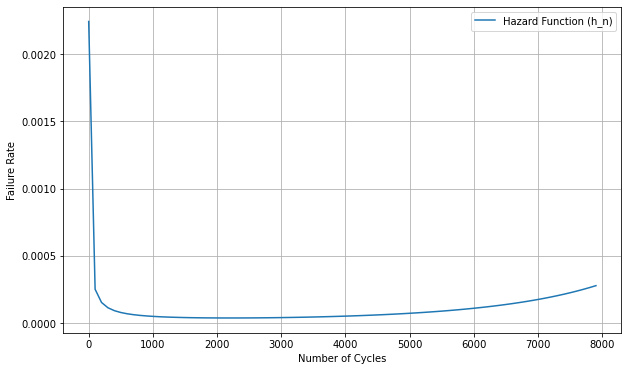

In [4]:
print(h_n_vals[-1])
plt.figure(figsize=(10, 6))
plt.plot(n_vals, h_n_vals, label='Hazard Function (h_n)')
plt.xlabel('Number of Cycles')
plt.ylabel('Failure Rate')
plt.legend()
plt.grid(True)

### Load Data

Text(0, 0.5, 'Frequency')

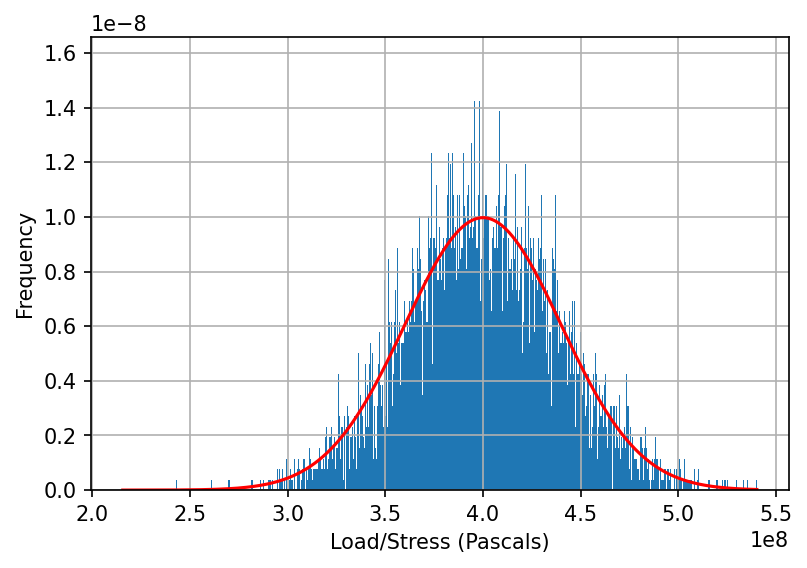

In [5]:
import math
original_strength=600 #MPa
num_cycles=np.linspace(0,8000,8000)



load_data=np.random.normal(400*10**6 #mean Newtons
                 ,40*10**6 #standard deviation
                 ,(np.shape(num_cycles)[0],)) #size Number of load cycles

xvals = np.linspace(min(load_data), max(load_data),np.shape(num_cycles)[0] )

plt.figure(dpi = 150)
plt.hist(load_data,bins=1000, density=True)
plt.plot(xvals, scistat.norm.pdf(xvals, loc=400*10**6, scale=40*10**6), 'r-', label='Fitted Normal PDF')
np.shape(load_data)
plt.grid(True)
plt.xlabel('Load/Stress (Pascals)')
plt.ylabel('Frequency')




## Strength Data

[5.49132542e+08 5.82540379e+08 6.18590825e+08 ... 5.46063905e+08
 5.54625612e+08 4.77265185e+08]


Text(0, 0.5, 'Frequency')

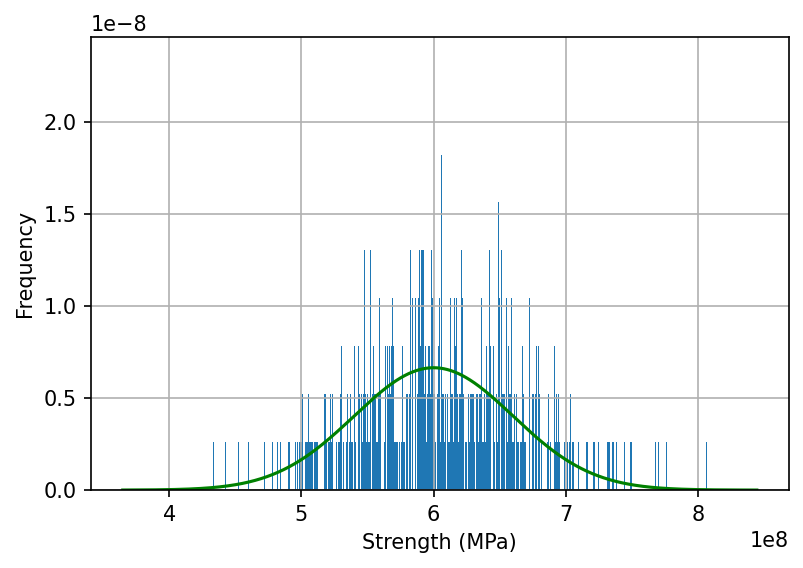

In [6]:
import numpy as np
import scipy.stats as scistat
import scipy.optimize as sciopt
import matplotlib.pyplot as plt


strength_data=np.random.normal(600*10**6 #mean Newtons
                 ,60*10**6 #standard deviation
                 ,np.shape(num_cycles)[0],) #size Number of load cycles
xvals = np.linspace(min(strength_data), max(strength_data),np.shape(num_cycles)[0] )
plt.figure(dpi = 150)
print(strength_data)
plt.hist(strength_data,bins=10000, density=True)
plt.plot(xvals, scistat.norm.pdf(xvals, loc=600*10**6, scale=60*10**6), 'g-', label='Fitted Normal PDF')
plt.grid(True)
plt.xlabel('Strength (MPa)')
plt.ylabel('Frequency')



## Residual Strength

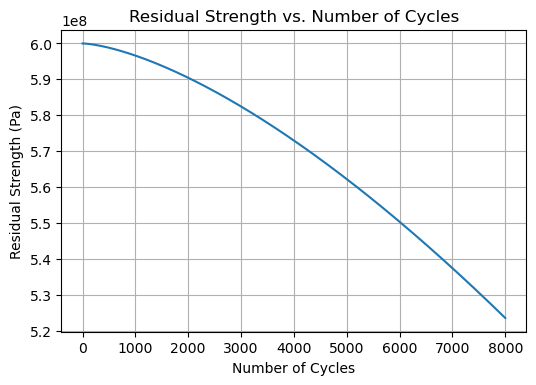

In [7]:
residual_strength_baseline=strength_degradation(n, strength_o, load, N, c)
num_cycles=np.linspace(0,8000,7901)

plt.figure(dpi=100)
plt.plot(num_cycles,residual_strength_baseline)
plt.xlabel('Number of Cycles')
plt.ylabel('Residual Strength (Pa)')
plt.title('Residual Strength vs. Number of Cycles')

plt.grid(True)
plt.show()




Optimal mean for normal distribution @Fatigue Life of 150000 over 8000Load Cycles and material coeffcient of 1.5 = 569422112.0201157
Optimal standard deviation for normal distribution @Fatigue Life of 150000 and 8000Load Cycles and material coeffcient of 1.5 = 22935431.294338357


Text(0, 0.5, 'Frequency')

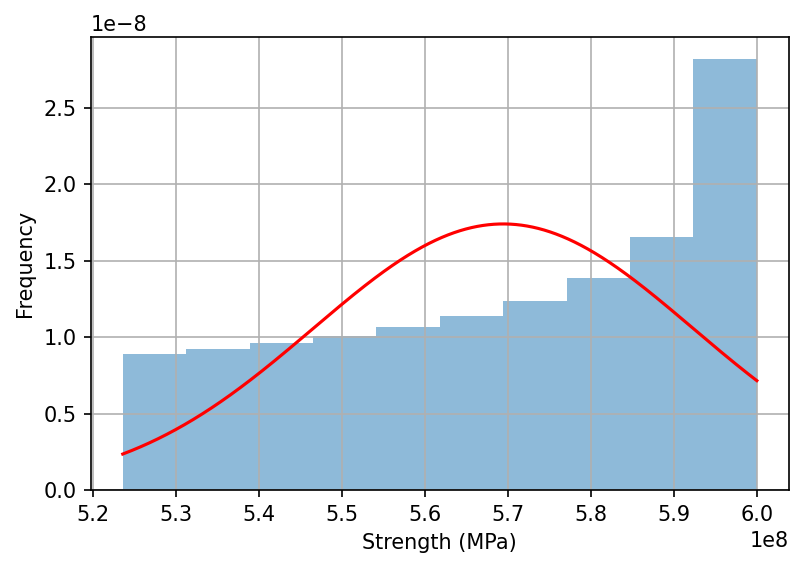

In [8]:
fatigue_life2=150000 
material_coeff4=1.5

# residual_strength_baseline=(strength_data-(strength_data-load_data)*(num_cycles/fatigue_life2)**material_coeff4)
residual_strength_baseline

# sorted_residual_strength_baseline = np.sort(residual_strength_baseline)[::-1]
# print('Sorted Residual Strength',sorted_residual_strength_baseline)



def normal_log_likelihood(param, data):
    mean = param[0]
    std_dev = param[1]
    neg_log_likelihood = -np.sum(scistat.norm.logpdf(data, loc=mean, scale=std_dev))
    return neg_log_likelihood

initial_guess = [1000, 500]
result_baseline = sciopt.minimize(fun=normal_log_likelihood, x0=initial_guess, args=(residual_strength_baseline,), method='Nelder-Mead')

optimal_mean_baseline = result_baseline['x'][0]
optimal_std_baseline = result_baseline['x'][1]
print('Optimal mean for normal distribution @Fatigue Life of 150000 over 8000Load Cycles and material coeffcient of 1.5 =', optimal_mean_baseline)
print('Optimal standard deviation for normal distribution @Fatigue Life of 150000 and 8000Load Cycles and material coeffcient of 1.5 =', optimal_std_baseline)

plt.figure(dpi = 150)
plt.hist(residual_strength_baseline, bins=10, density=True, alpha=0.5, label='Residual Strength')
xvals = np.linspace(min(residual_strength_baseline), max(residual_strength_baseline), np.shape(num_cycles)[0])
plt.plot(xvals, scistat.norm.pdf(xvals, loc=optimal_mean_baseline, scale=optimal_std_baseline), 'r-', label='Fitted Normal PDF')
plt.grid(True)
plt.xlabel('Strength (MPa)')
plt.ylabel('Frequency')

## PF Curve

In [9]:
# min_residual_strength = np.min(sorted_residual_strength_baseline)
# print(min_residual_strength)
# gradient=(np.max(sorted_residual_strength_baseline)-np.min(sorted_residual_strength_baseline))/np.max(sorted_residual_strength_baseline)
# print(gradient)
# residual_strength_adjusted = residual_strength_baseline - min_residual_strength
# print(residual_strength_adjusted)



# D_i = np.min(residual_strength_adjusted)# Initial damage
# print(D_i)
# # D_i = 0  # Initial damage
# n = gradient
# fatigue_life2=150000
# t_f = 8000 

# def calculate_condition(D_i, t, t_f, n):
#     term = D_i**n + (t / t_f) * (1 - D_i**n)
#     condition = 1 - term**(1/n)
#     return condition

# time_values = num_cycles #cycle values


# condition_values = [calculate_condition(D_i, t, t_f, n) for t in time_values]

# plt.figure(dpi=150)
# plt.plot(time_values, condition_values, label=f'D_i = {D_i}, t_f = {t_f}, n = {n}')
# plt.xlabel('Cycles')
# plt.ylabel('Condition')
# plt.title('Condition vs Time')
# plt.grid(True)


# Cost Modeling as a demonstration

Optimal preventative cost = R 4.652684257882635 per Cycle
Optimal preventative time = 4455.696202531645 Cycles


C:\Users\user\AppData\Local\Temp/ipykernel_8160/2176844634.py:24: RuntimeWarning: divide by zero encountered in true_divide
  Cph = C / Le
C:\Users\user\AppData\Local\Temp/ipykernel_8160/2176844634.py:25: RuntimeWarning: divide by zero encountered in true_divide
  Cph_c=C2/Le


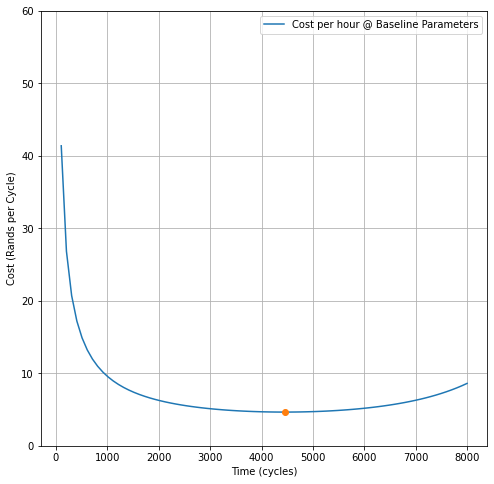

In [10]:
import scipy.integrate as scint
Cc = 60000
Cp = 650
tp=np.linspace(0,8000,80)
tc = []
def  integrand(t):
    return t*scistat.norm.pdf(t, loc=optimal_mean_baseline, scale=optimal_std_baseline)
#     return t*scistat.norm.pdf(t, loc=optimal_mean_baseline, scale=optimal_std_baseline)

for i in range(len(tp)):
    int1, error = scint.quad(integrand, 0,tp[i])
    tc.append(int1)

    
reliability_baseline=np.array(R_n_vals)   
tc=np.array(tc)/(1-np.array(R_n_vals))

Le = ((tp) * reliability_baseline) + (tc) * (1 - reliability_baseline)


C = Cp * reliability_baseline + Cc * (1 - reliability_baseline)
C2= Cc * (1 - reliability_baseline) #corrective maintenance only

Cph = C / Le
Cph_c=C2/Le



# plt.figure(dpi=120)
plt.figure(figsize=(8, 8))
plt.plot(tp, Cph, label="Cost per hour @ Baseline Parameters")
# plt.plot(tp, Cph_c, label="Cost per hour considering Corrective Maintenance Only @ Baseline Parameters")

idx_min = np.argmin(Cph)


xmin = tp[idx_min]
ymin = np.nanmin(Cph)


plt.plot(xmin, ymin, 'o')


print('Optimal preventative cost = R', ymin, "per Cycle")
print('Optimal preventative time =', xmin, 'Cycles')



plt.xlabel('Time (cycles)')
plt.ylabel("Cost (Rands per Cycle)")
plt.ylim(0,60)
plt.legend()
plt.grid(True)
plt.show()




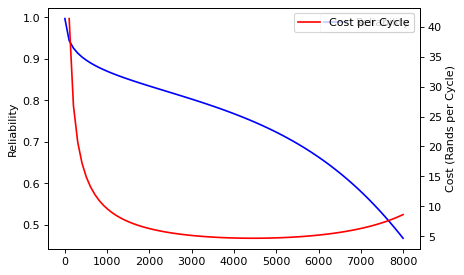

In [11]:
plt.figure(dpi=80)
plt.plot(tp, reliability_baseline, color='blue', label='Reliability')
plt.legend()
plt.ylabel('Reliability')
plt.legend()

plt.twinx()
plt.plot(tp, Cph, color='red', label='Cost per Cycle')
plt.ylabel('Cost (Rands per Cycle)')
plt.xlabel('Cycles')
plt.legend()

# plt.plot(tp, Cph)
# plt.plot(xvals1, reliability_baseline)
# plt.ylim(0,60)

# Sensitivity Analysis

## Load & Strength

I have the equation: residual_strength=(strength_data-(strength_data-load_data)*(num_cycles/fatigue_life2)**material_coeff4) & I am conducting an analysis in python where I am varying the load by increasing number of cycles from 8000 to 500000. However, I fear that the shapes of my results will be different hence plotting will not occur i.e  num_cycles1=np.linspace(0,8000,8000)
num_cycles2=np.linspace(0,15000,15000)
num_cycles3=np.linspace(0,100000,100000)
num_cycles4=np.linspace(0,200000,200000)
num_cycles5=np.linspace(0,300000,300000)
num_cycles6=np.linspace(0,500000,500000)  how do i vary these without using linspace

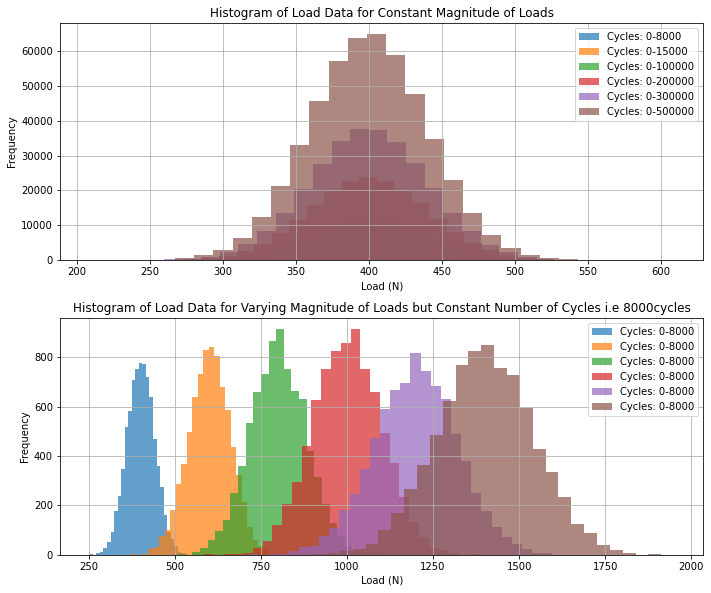

In [12]:
import math
original_strength=600 #MPa
# num_cycles1=np.linspace(0,8000,8000)
# 8000, 15000, 100000, 200000, 300000,500000
# num_cycles2=np.linspace(0,15000,15000)
# num_cycles3=np.linspace(0,100000,100000)
# num_cycles4=np.linspace(0,200000,200000)
# num_cycles5=np.linspace(0,300000,300000)
# num_cycles6=np.linspace(0,500000,300000)

num_cycles1 = np.arange(0, 8000, 1)
num_cycles2 = np.arange(0, 15000, 1)
num_cycles3 = np.arange(0, 100000, 1)
num_cycles4 = np.arange(0, 200000, 1)
num_cycles5 = np.arange(0, 300000, 1)
num_cycles6 = np.arange(0, 500000, 1)



load_data_c1=np.random.normal(400 ,40,(np.shape(num_cycles1)[0],)) 
load_data_c2=np.random.normal(400 ,40,(np.shape(num_cycles2)[0],)) 
load_data_c3=np.random.normal(400 ,40,(np.shape(num_cycles3)[0],))
load_data_c4=np.random.normal(400 ,40,(np.shape(num_cycles4)[0],))
load_data_c5=np.random.normal(400 ,40,(np.shape(num_cycles5)[0],))
load_data_c6=np.random.normal(400 ,40,(np.shape(num_cycles6)[0],))

load_data_v1=np.random.normal(400 ,40,(np.shape(num_cycles1)[0],)) 
load_data_v2=np.random.normal(600 ,60,(np.shape(num_cycles2)[0],)) 
load_data_v3=np.random.normal(800 ,80,(np.shape(num_cycles3)[0],))
load_data_v4=np.random.normal(1000 ,100,(np.shape(num_cycles4)[0],))
load_data_v5=np.random.normal(1200 ,120,(np.shape(num_cycles5)[0],))
load_data_v6=np.random.normal(1400 ,140,(np.shape(num_cycles6)[0],))

load_data_vc1=np.random.normal(400 ,40,(np.shape(num_cycles)[0],)) 
load_data_vc2=np.random.normal(600 ,60,(np.shape(num_cycles)[0],)) 
load_data_vc3=np.random.normal(800 ,80,(np.shape(num_cycles)[0],))
load_data_vc4=np.random.normal(1000 ,100,(np.shape(num_cycles)[0],))
load_data_vc5=np.random.normal(1200 ,120,(np.shape(num_cycles)[0],))
load_data_vc6=np.random.normal(1400 ,140,(np.shape(num_cycles)[0],))

plt.figure(figsize=(10, 12))

plt.subplot(3, 1, 1)
plt.hist(load_data_c1, bins=30, alpha=0.7, label='Cycles: 0-8000')
plt.hist(load_data_c2, bins=30, alpha=0.7, label='Cycles: 0-15000')
plt.hist(load_data_c3, bins=30, alpha=0.7, label='Cycles: 0-100000')
plt.hist(load_data_c4, bins=30, alpha=0.7, label='Cycles: 0-200000')
plt.hist(load_data_c5, bins=30, alpha=0.7, label='Cycles: 0-300000')
plt.hist(load_data_c6, bins=30, alpha=0.7, label='Cycles: 0-500000')
plt.title('Histogram of Load Data for Constant Magnitude of Loads')
plt.xlabel('Load (N)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.hist(load_data_vc1, bins=30, alpha=0.7, label='Cycles: 0-8000')
plt.hist(load_data_vc2, bins=30, alpha=0.7, label='Cycles: 0-8000')
plt.hist(load_data_vc3, bins=30, alpha=0.7, label='Cycles: 0-8000')
plt.hist(load_data_vc4, bins=30, alpha=0.7, label='Cycles: 0-8000')
plt.hist(load_data_vc5, bins=30, alpha=0.7, label='Cycles: 0-8000')
plt.hist(load_data_vc6, bins=30, alpha=0.7, label='Cycles: 0-8000')
plt.title('Histogram of Load Data for Varying Magnitude of Loads but Constant Number of Cycles i.e 8000cycles')
plt.xlabel('Load (N)')
plt.ylabel('Frequency')
plt.legend()

# plt.subplot(3, 1, 3)
# plt.hist(load_data_v1, bins=30, alpha=0.7, label='Cycles: 0-8000')
# plt.hist(load_data_v2, bins=30, alpha=0.7, label='Cycles: 0-15000')
# plt.hist(load_data_v3, bins=30, alpha=0.7, label='Cycles: 0-100000')
# plt.hist(load_data_v4, bins=30, alpha=0.7, label='Cycles: 0-1000000')
# plt.title('Histogram of Load Data for Varying Magnitude of Loads')
# plt.xlabel('Load (N)')
# plt.ylabel('Frequency')
# plt.legend()
plt.grid(True)





plt.tight_layout()
plt.show()

xvals = np.linspace(min(load_data), max(load_data),np.shape(num_cycles1)[0] )






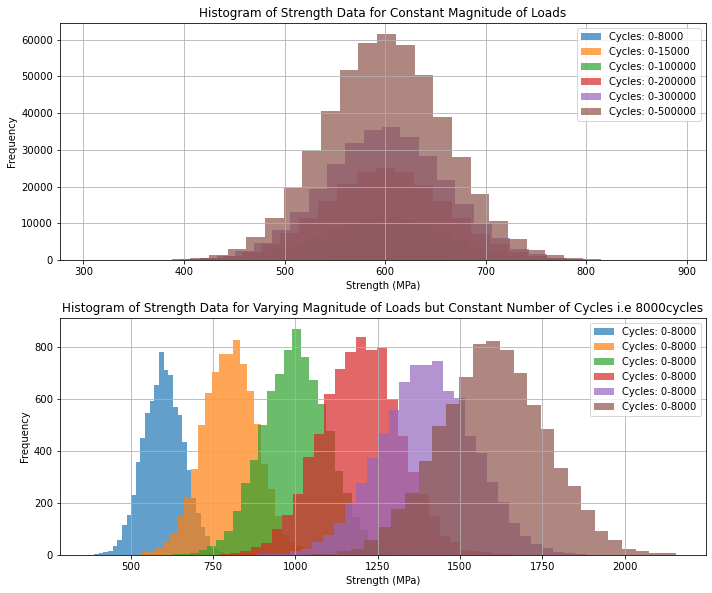

In [13]:


strength_data_c1=np.random.normal(600,60,np.shape(num_cycles1)[0],)
strength_data_c2=np.random.normal(600,60,np.shape(num_cycles2)[0],) 
strength_data_c3=np.random.normal(600,60,np.shape(num_cycles3)[0],) 
strength_data_c4=np.random.normal(600,60,np.shape(num_cycles4)[0],)
strength_data_c5=np.random.normal(600,60,np.shape(num_cycles5)[0],)
strength_data_c6=np.random.normal(600,60,np.shape(num_cycles6)[0],)


strength_data_vc1=np.random.normal(600 ,60,(np.shape(num_cycles)[0],)) 
strength_data_vc2=np.random.normal(800 ,80,(np.shape(num_cycles)[0],)) 
strength_data_vc3=np.random.normal(1000 ,100,(np.shape(num_cycles)[0],))
strength_data_vc4=np.random.normal(1200 ,120,(np.shape(num_cycles)[0],))
strength_data_vc5=np.random.normal(1400 ,140,(np.shape(num_cycles)[0],))
strength_data_vc6=np.random.normal(1600 ,160,(np.shape(num_cycles)[0],))


# strength_data_v1=np.random.normal(600 ,60,(np.shape(num_cycles1)[0],)) 
# strength_data_v2=np.random.normal(800 ,80,(np.shape(num_cycles2)[0],)) 
# strength_data_v3=np.random.normal(1000 ,100,(np.shape(num_cycles3)[0],))
# strength_data_v4=np.random.normal(1200 ,120,(np.shape(num_cycles4)[0],))
# strength_data_v5=np.random.normal(1400 ,140,(np.shape(num_cycles5)[0],))
# strength_data_v6=np.random.normal(1600 ,160,(np.shape(num_cycles6)[0],))


plt.figure(figsize=(10, 12))

plt.subplot(3, 1, 1)
plt.hist(strength_data_c1, bins=30, alpha=0.7, label='Cycles: 0-8000')
plt.hist(strength_data_c2, bins=30, alpha=0.7, label='Cycles: 0-15000')
plt.hist(strength_data_c3, bins=30, alpha=0.7, label='Cycles: 0-100000')
plt.hist(strength_data_c4, bins=30, alpha=0.7, label='Cycles: 0-200000')
plt.hist(strength_data_c5, bins=30, alpha=0.7, label='Cycles: 0-300000')
plt.hist(strength_data_c6, bins=30, alpha=0.7, label='Cycles: 0-500000')
plt.title('Histogram of Strength Data for Constant Magnitude of Loads')
plt.xlabel('Strength (MPa)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.hist(strength_data_vc1, bins=30, alpha=0.7, label='Cycles: 0-8000')
plt.hist(strength_data_vc2, bins=30, alpha=0.7, label='Cycles: 0-8000')
plt.hist(strength_data_vc3, bins=30, alpha=0.7, label='Cycles: 0-8000')
plt.hist(strength_data_vc4, bins=30, alpha=0.7, label='Cycles: 0-8000')
plt.hist(strength_data_vc5, bins=30, alpha=0.7, label='Cycles: 0-8000')
plt.hist(strength_data_vc6, bins=30, alpha=0.7, label='Cycles: 0-8000')
plt.title('Histogram of Strength Data for Varying Magnitude of Loads but Constant Number of Cycles i.e 8000cycles')
plt.xlabel('Strength (MPa)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

# plt.subplot(3, 1, 3)
# plt.hist(strength_data_v1, bins=30, alpha=0.7, label='Cycles: 0-8000')
# plt.hist(strength_data_v2, bins=30, alpha=0.7, label='Cycles: 0-15000')
# plt.hist(strength_data_v3, bins=30, alpha=0.7, label='Cycles: 0-100000')
# plt.hist(strength_data_v4, bins=30, alpha=0.7, label='Cycles: 0-200000')
# plt.hist(strength_data_v5, bins=30, alpha=0.7, label='Cycles: 0-300000')
# plt.hist(strength_data_v6, bins=30, alpha=0.7, label='Cycles: 0-500000')
# plt.title('Histogram of Strength Data for Varying Magnitude of Loads')
# plt.xlabel('Strength (MPa)')
# plt.ylabel('Frequency')
# plt.legend()
# plt.grid(True)



plt.tight_layout()
plt.show()



## Reliability & Hazard Rate

### Varying number of cycles

In [14]:
# 8000, 15000, 100000, 200000, 300000,500000

n_vals1 = np.arange(1, 8000, 100)
n_vals2 = np.arange(1, 10000, 100)
n_vals3 = np.arange(1, 15000, 100)
# n_vals4 = np.arange(1, 200000, 100)
# n_vals5 = np.arange(1, 300000, 100)
# n_vals5 = np.arange(1, 500000, 100)
residual_strength_baseline=strength_degradation(n, strength_o, load, N, c)

# Calculate R_n and h_n for each n
R_n_vals1 = []
h_n_vals1 = []
for n in n_vals1:
    R_n_vals1.append(R_n_new(n, mu_strength, sigma_strength, mu_load, sigma_load, N, c))
    h_n_vals1.append(h_n_new(n, mu_strength, sigma_strength, mu_load, sigma_load, N, c))
R_n_vals2 = []
h_n_vals2 = []   
for n in n_vals2:
    R_n_vals2.append(R_n_new(n, mu_strength, sigma_strength, mu_load, sigma_load, N, c))
    h_n_vals2.append(h_n_new(n, mu_strength, sigma_strength, mu_load, sigma_load, N, c))

In [15]:
R_n_vals3 = []
h_n_vals3 = []   
for n in n_vals3:
    R_n_vals3.append(R_n_new(n, mu_strength, sigma_strength, mu_load, sigma_load, N, c))
    h_n_vals3.append(h_n_new(n, mu_strength, sigma_strength, mu_load, sigma_load, N, c))

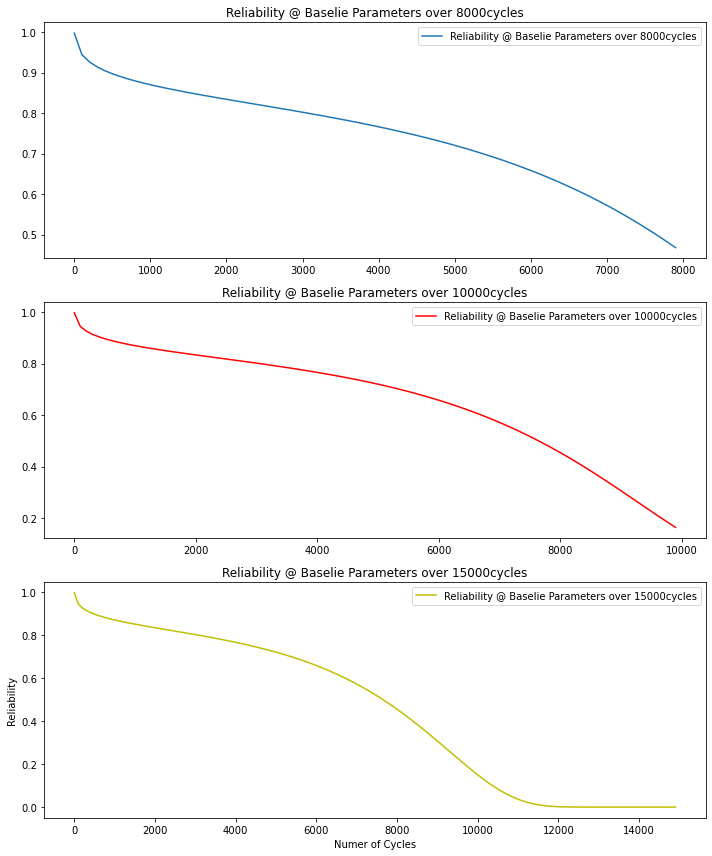

In [16]:
array1=np.array(R_n_vals1)
array2=np.array(R_n_vals2)
array3=np.array(R_n_vals3)

x_common = np.linspace(0, 100000, 100000)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

ax1.plot(n_vals1,array1, label='Reliability @ Baselie Parameters over 8000cycles')
ax1.set_title('Reliability @ Baselie Parameters over 8000cycles')
ax1.legend()
plt.xlabel('Numer of Cycles')
plt.ylabel('Reliability')

ax2.plot(n_vals2,array2, label='Reliability @ Baselie Parameters over 10000cycles',color='r')
ax2.set_title('Reliability @ Baselie Parameters over 10000cycles')
ax2.legend()
plt.xlabel('Numer of Cycles')
plt.ylabel('Reliability')

ax3.plot(n_vals3,array3, label='Reliability @ Baselie Parameters over 15000cycles', color='y')
ax3.set_title('Reliability @ Baselie Parameters over 15000cycles')
ax3.legend()
plt.xlabel('Numer of Cycles')
plt.ylabel('Reliability')

plt.tight_layout()
plt.show()


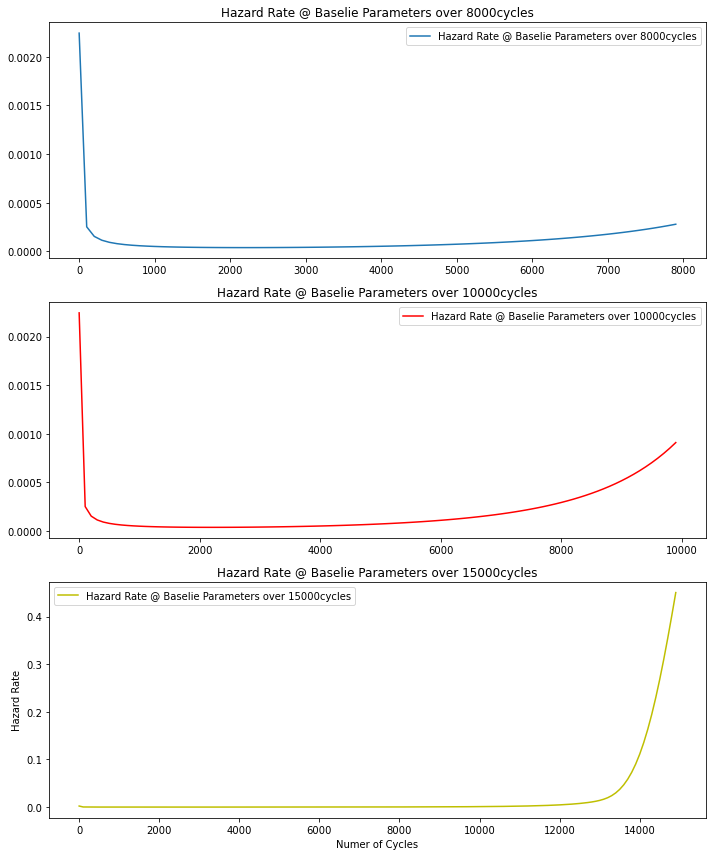

In [17]:
array4=np.array(h_n_vals1)
array5=np.array(h_n_vals2)
array6=np.array(h_n_vals3)

x_common = np.linspace(0, 100000, 100000)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

ax1.plot(n_vals1,array4, label='Hazard Rate @ Baselie Parameters over 8000cycles')
ax1.set_title('Hazard Rate @ Baselie Parameters over 8000cycles')
ax1.legend()
plt.xlabel('Numer of Cycles')
plt.ylabel('Hazard Rate')

ax2.plot(n_vals2,array5, label='Hazard Rate @ Baselie Parameters over 10000cycles',color='r')
ax2.set_title('Hazard Rate @ Baselie Parameters over 10000cycles')
ax2.legend()
plt.xlabel('Numer of Cycles')
plt.ylabel('Hazard Rate')

ax3.plot(n_vals3,array6, label='Hazard Rate @ Baselie Parameters over 15000cycles', color='y')
ax3.set_title('Hazard Rate @ Baselie Parameters over 15000cycles')
ax3.legend()
plt.xlabel('Numer of Cycles')
plt.ylabel('Hazard Rate')

plt.tight_layout()
plt.show()

### Varying Magnitude of Load

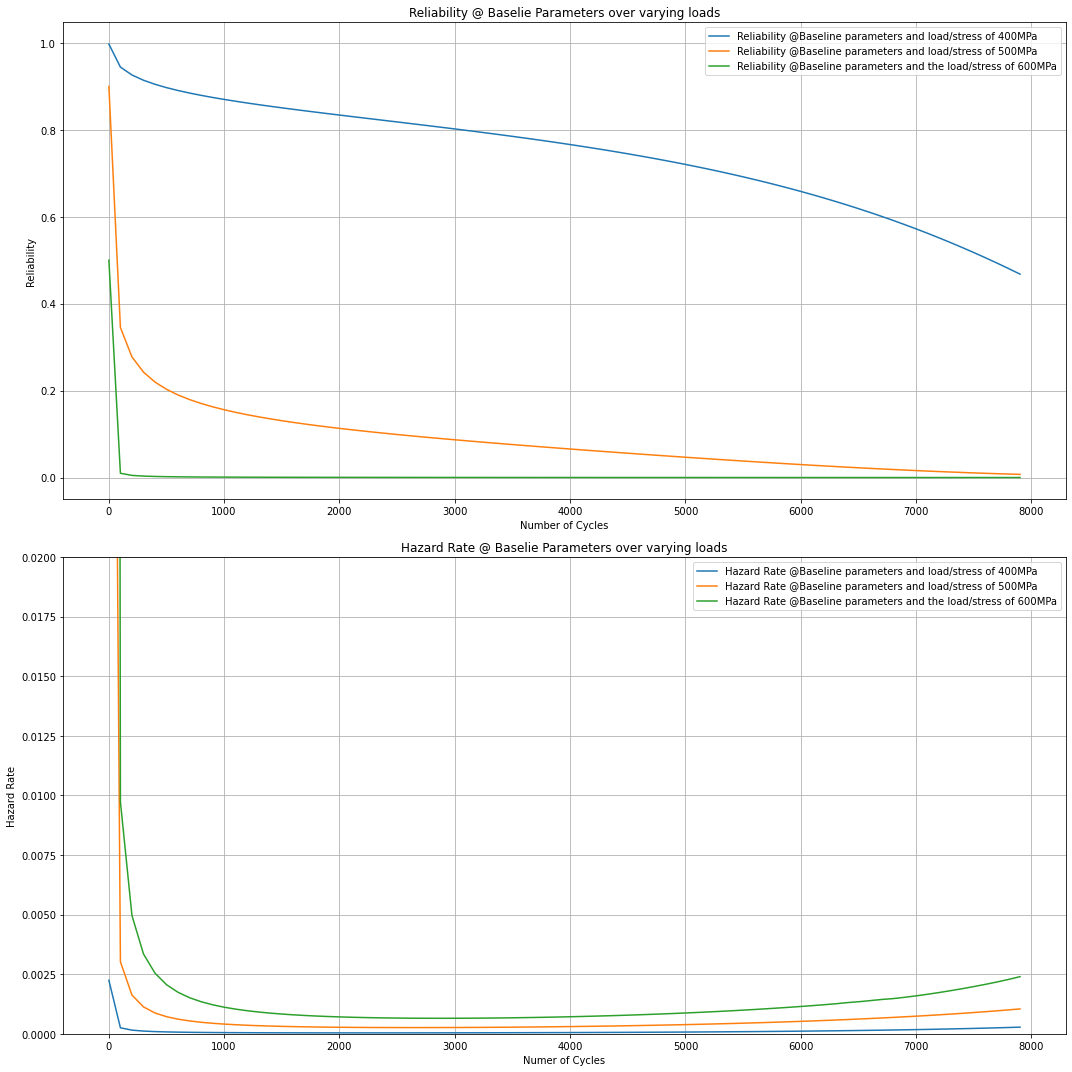

In [18]:
mu_load1 = 400 * 10**6
sigma_load1 = 40 * 10**6

mu_load2 = 500 * 10**6
sigma_load2 = 50 * 10**6

mu_load3 = 600 * 10**6
sigma_load3 = 60 * 10**6


n_vals = np.arange(1, 8000, 100)
R_n_vals1_vl = []
h_n_vals1_vl = []
R_n_vals2_vl = []
h_n_vals2_vl = []
R_n_vals3_vl = []
h_n_vals3_vl = []

for n in n_vals:
    R_n_vals1_vl.append(R_n_new(n, mu_strength, sigma_strength, mu_load1, sigma_load1, N, c))
    h_n_vals1_vl.append(h_n_new(n, mu_strength, sigma_strength, mu_load1, sigma_load1, N, c))
    R_n_vals2_vl.append(R_n_new(n, mu_strength, sigma_strength, mu_load2, sigma_load2, N, c))
    h_n_vals2_vl.append(h_n_new(n, mu_strength, sigma_strength, mu_load2, sigma_load2, N, c))
    R_n_vals3_vl.append(R_n_new(n, mu_strength, sigma_strength, mu_load3, sigma_load3, N, c))
    h_n_vals3_vl.append(h_n_new(n, mu_strength, sigma_strength, mu_load3, sigma_load3, N, c))
    
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15))
ax1.set_title('Reliability @ Baselie Parameters over varying loads')
ax1.plot(figsize=(15, 15))
ax1.plot(n_vals,R_n_vals1_vl, label= 'Reliability @Baseline parameters and load/stress of 400MPa')
ax1.plot(n_vals,R_n_vals2_vl, label='Reliability @Baseline parameters and load/stress of 500MPa')
ax1.plot(n_vals,R_n_vals3_vl,label='Reliability @Baseline parameters and the load/stress of 600MPa')
ax1.set_xlabel('Number of Cycles')
ax1.set_ylabel('Reliability')
ax1.legend()
ax1.grid(True)


ax2.set_title('Hazard Rate @ Baselie Parameters over varying loads')
ax2.plot(figsize=(10, 12))
ax2.plot(n_vals,h_n_vals1_vl, label= 'Hazard Rate @Baseline parameters and load/stress of 400MPa')
ax2.plot(n_vals,h_n_vals2_vl, label='Hazard Rate @Baseline parameters and load/stress of 500MPa')
ax2.plot(n_vals,h_n_vals3_vl,label='Hazard Rate @Baseline parameters and the load/stress of 600MPa')
plt.xlabel('Numer of Cycles')
plt.ylabel('Hazard Rate')
plt.ylim(0,0.020)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Varying material coefficient

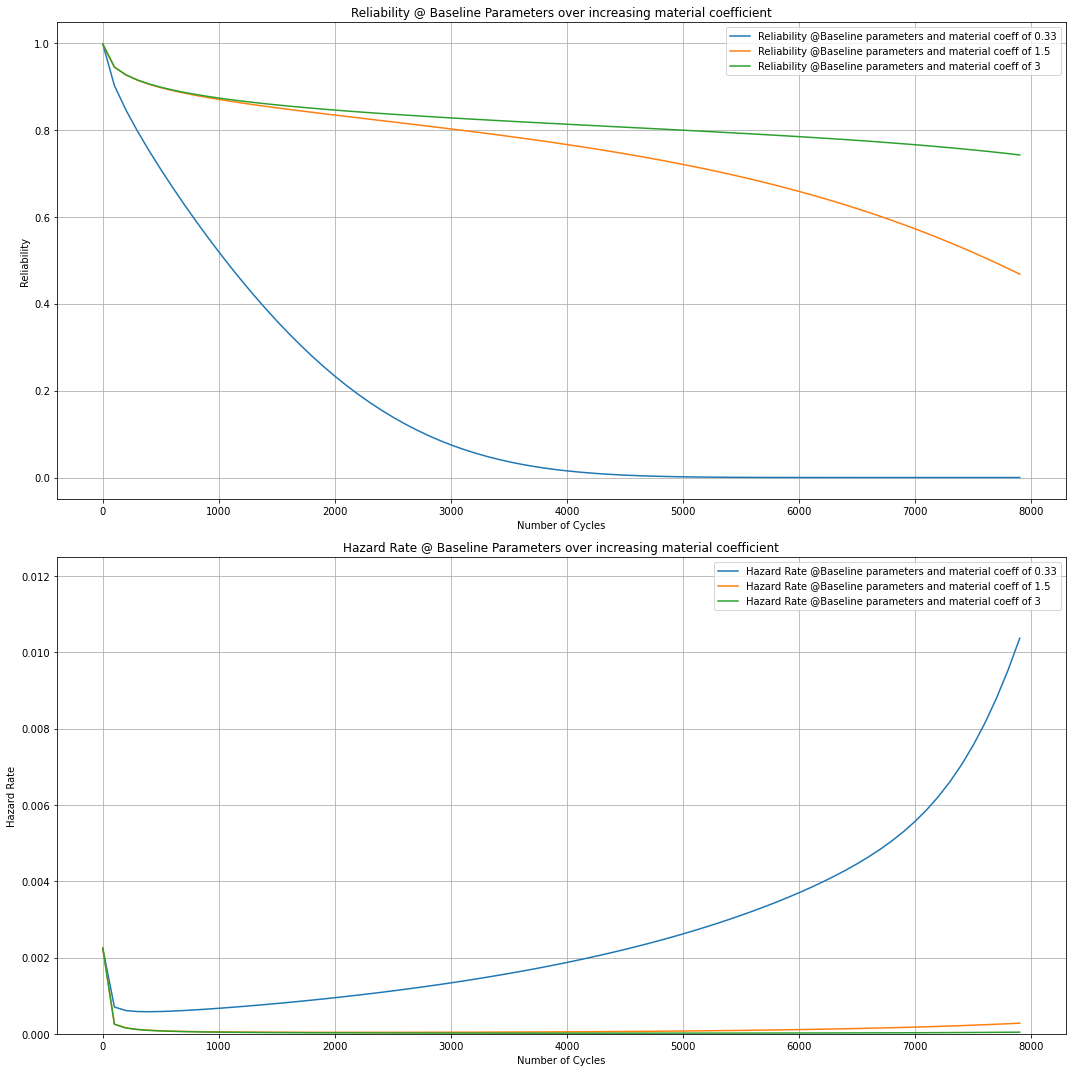

In [19]:
c1=0.33
c2=1.5
c3=3


n_vals = np.arange(1, 8000, 100)
R_n_vals1_vc = []
h_n_vals1_vc = []
R_n_vals2_vc = []
h_n_vals2_vc = []
R_n_vals3_vc = []
h_n_vals3_vc = []

for n in n_vals:
    R_n_vals1_vc.append(R_n_new(n, mu_strength, sigma_strength, mu_load, sigma_load, N, c1))
    h_n_vals1_vc.append(h_n_new(n, mu_strength, sigma_strength, mu_load, sigma_load, N, c1))
    R_n_vals2_vc.append(R_n_new(n, mu_strength, sigma_strength, mu_load, sigma_load, N, c2))
    h_n_vals2_vc.append(h_n_new(n, mu_strength, sigma_strength, mu_load, sigma_load, N, c2))
    R_n_vals3_vc.append(R_n_new(n, mu_strength, sigma_strength, mu_load, sigma_load, N, c3))
    h_n_vals3_vc.append(h_n_new(n, mu_strength, sigma_strength, mu_load, sigma_load, N, c3))
    
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15))
ax1.set_title('Reliability @ Baseline Parameters over increasing material coefficient')
ax1.plot(n_vals, R_n_vals1_vc, label='Reliability @Baseline parameters and material coeff of 0.33')
ax1.plot(n_vals, R_n_vals2_vc, label='Reliability @Baseline parameters and material coeff of 1.5')
ax1.plot(n_vals, R_n_vals3_vc, label='Reliability @Baseline parameters and material coeff of 3')
ax1.set_xlabel('Number of Cycles')
ax1.set_ylabel('Reliability')
ax1.legend()
ax1.grid(True)

ax2.set_title('Hazard Rate @ Baseline Parameters over increasing material coefficient')
ax2.plot(n_vals, h_n_vals1_vc, label='Hazard Rate @Baseline parameters and material coeff of 0.33')
ax2.plot(n_vals, h_n_vals2_vc, label='Hazard Rate @Baseline parameters and material coeff of 1.5')
ax2.plot(n_vals, h_n_vals3_vc, label='Hazard Rate @Baseline parameters and material coeff of 3')
ax2.set_xlabel('Number of Cycles')
ax2.set_ylabel('Hazard Rate')
ax2.set_ylim(0, 0.01250)
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

### Varying fatigue life

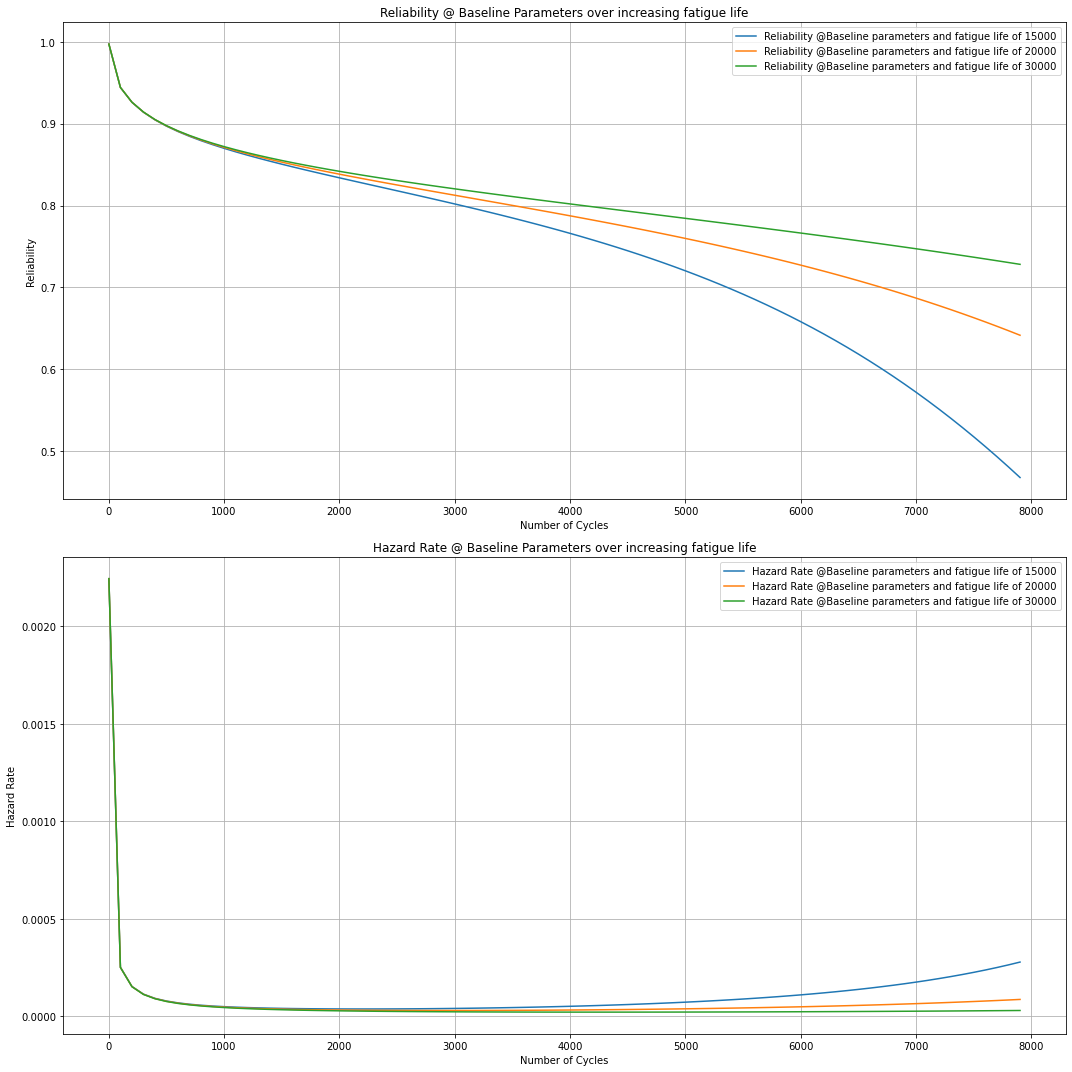

In [21]:
N1=15000
N2=20000
N3=30000

n_vals = np.arange(1, 8000, 100)
R_n_vals1_vN = []
h_n_vals1_vN = []
R_n_vals2_vN = []
h_n_vals2_vN = []
R_n_vals3_vN = []
h_n_vals3_vN = []

for n in n_vals:
    R_n_vals1_vN.append(R_n_new(n, mu_strength, sigma_strength, mu_load, sigma_load, N1, c))
    h_n_vals1_vN.append(h_n_new(n, mu_strength, sigma_strength, mu_load, sigma_load, N1, c))
    R_n_vals2_vN.append(R_n_new(n, mu_strength, sigma_strength, mu_load, sigma_load, N2, c))
    h_n_vals2_vN.append(h_n_new(n, mu_strength, sigma_strength, mu_load, sigma_load, N2, c))
    R_n_vals3_vN.append(R_n_new(n, mu_strength, sigma_strength, mu_load, sigma_load, N3, c))
    h_n_vals3_vN.append(h_n_new(n, mu_strength, sigma_strength, mu_load, sigma_load, N3, c))
    
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15))
ax1.set_title('Reliability @ Baseline Parameters over increasing fatigue life')
ax1.plot(n_vals, R_n_vals1_vN, label='Reliability @Baseline parameters and fatigue life of 15000')
ax1.plot(n_vals, R_n_vals2_vN, label='Reliability @Baseline parameters and fatigue life of 20000')
ax1.plot(n_vals, R_n_vals3_vN, label='Reliability @Baseline parameters and fatigue life of 30000')
ax1.set_xlabel('Number of Cycles')
ax1.set_ylabel('Reliability')
ax1.legend()
ax1.grid(True)

ax2.set_title('Hazard Rate @ Baseline Parameters over increasing fatigue life')
ax2.plot(n_vals, h_n_vals1_vN, label='Hazard Rate @Baseline parameters and fatigue life of 15000')
ax2.plot(n_vals, h_n_vals2_vN, label='Hazard Rate @Baseline parameters and fatigue life of 20000')
ax2.plot(n_vals, h_n_vals3_vN, label='Hazard Rate @Baseline parameters and fatigue life of 30000')
ax2.set_xlabel('Number of Cycles')
ax2.set_ylabel('Hazard Rate')
# ax2.set_ylim(0, 0.01250)
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## Residual Strength by Varying Number of Load Cycles

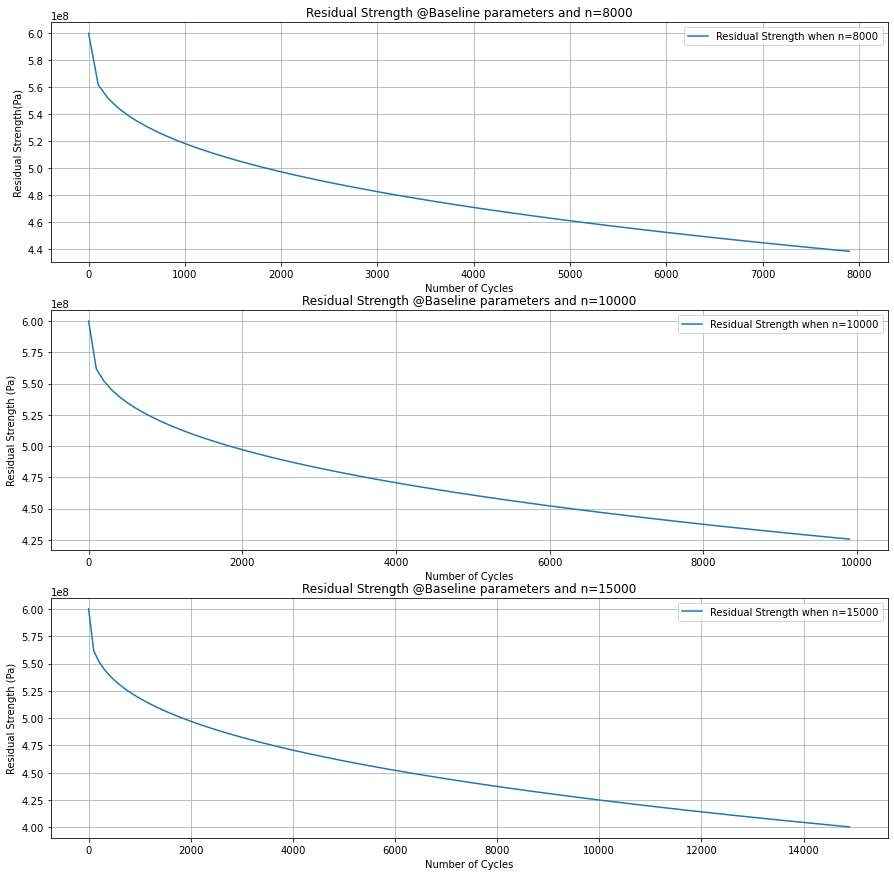

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Define the strength degradation function
def strength_degradation(n_vals, strength_original, mean_load, N, c):
    delta_new = []
    for n in n_vals:
        delta = strength_original - (strength_original - mean_load) * ((n-1) / N) ** c
        delta_new.append(delta)
    return delta_new

# Parameters
strength_original = 600 * 10**6
load = 400 * 10**6
mu_strength = 600 * 10**6
sigma_strength = 60 * 10**6
mu_load = 400 * 10**6
sigma_load = 40 * 10**6
N = 15000
c1 = 0.33


# n_vals arrays
n_vals1 = np.arange(1, 8000, 100)
n_vals2 = np.arange(1, 10000, 100)
n_vals3 = np.arange(1, 15000, 100)

# Calculate residual strengths
residual_strength1_c1 = strength_degradation(n_vals1, strength_original, load, N, c1)
residual_strength2_c1 = strength_degradation(n_vals2, strength_original, load, N, c1)
residual_strength3_c1 = strength_degradation(n_vals3, strength_original, load, N, c1)


# Plotting
fig, ax = plt.subplots(3, 1, figsize=(15, 15))

ax[0].set_title('Residual Strength @Baseline parameters and n=8000')
ax[0].plot(n_vals1, residual_strength1_c1, label='Residual Strength when n=8000')
ax[0].set_xlabel('Number of Cycles')
ax[0].set_ylabel('Residual Strength(Pa)')
ax[0].legend()
ax[0].grid(True)

ax[1].set_title('Residual Strength @Baseline parameters and n=10000')
ax[1].plot(n_vals2, residual_strength2_c1, label='Residual Strength when n=10000')
ax[1].set_xlabel('Number of Cycles')
ax[1].set_ylabel('Residual Strength (Pa)')
ax[1].legend()
ax[1].grid(True)

ax[2].set_title('Residual Strength @Baseline parameters and n=15000')
ax[2].plot(n_vals3, residual_strength3_c1, label='Residual Strength when n=15000')
ax[2].set_xlabel('Number of Cycles')
ax[2].set_ylabel('Residual Strength (Pa)')
ax[2].legend()
ax[2].grid(True)



In [23]:
def normal_log_likelihood(param, data):
    mean = param[0]
    std_dev = param[1]
    neg_log_likelihood = -np.sum(scistat.norm.logpdf(data, loc=mean, scale=std_dev))
    return neg_log_likelihood

initial_guess = [1000, 500]
result_c1 = sciopt.minimize(fun=normal_log_likelihood, x0=initial_guess, args=(residual_strength1_c1,), method='Nelder-Mead')
result_c2 = sciopt.minimize(fun=normal_log_likelihood, x0=initial_guess, args=(residual_strength2_c1,), method='Nelder-Mead')
result_c3 = sciopt.minimize(fun=normal_log_likelihood, x0=initial_guess, args=(residual_strength3_c1,), method='Nelder-Mead')


mean_c1 = result_c1['x'][0]
std_c1 = result_c1['x'][1]
print('Mean @8000cycles ',mean_c1)
print('STD @8000cycles ',std_c1)

mean_c2 = result_c2['x'][0]
std_c2 = result_c2['x'][1]
print('Mean @10000cycles ',mean_c2)
print('STD @10000cycles ',std_c2)

mean_c3 = result_c3['x'][0]
std_c3 = result_c3['x'][1]
print('Mean @15000cycles ',mean_c3)
print('STD @15000cycles ',std_c3)






Mean @8000cycles  478943881.4528421
STD @8000cycles  33035719.6639192
Mean @10000cycles  469437898.1337421
STD @10000cycles  35172742.533589885
Mean @15000cycles  450361663.45992136
STD @15000cycles  39623017.415277496


## Residual Strength by Varying Magnitude of load

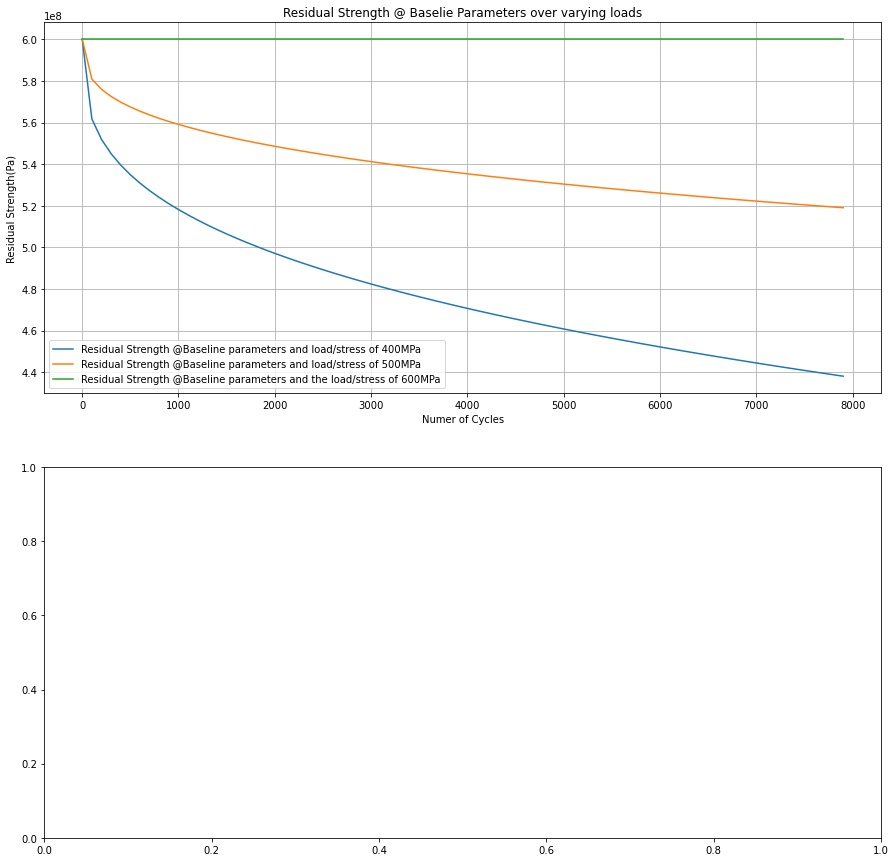

In [24]:
load1 = 400 * 10**6
load2 = 500 * 10**6
load3 = 600 * 10**6

loadx=np.arange(400*10**6, 599*10**6, 100)
n_vals1 = np.arange(1, 8000, 100)
residual_strength1_vl = strength_degradation(n_vals1, strength_original, load1, N, c1)
residual_strength2_vl = strength_degradation(n_vals1, strength_original, load2, N, c1)
residual_strength3_vl = strength_degradation(n_vals1, strength_original, load3, N, c1)

fig, ax = plt.subplots(2, 1, figsize=(15, 15))
ax[0].set_title('Residual Strength @ Baselie Parameters over varying loads')
ax[0].plot(figsize=(15, 15))
ax[0].plot(n_vals,residual_strength1_vl, label= 'Residual Strength @Baseline parameters and load/stress of 400MPa')
ax[0].plot(n_vals,residual_strength2_vl, label='Residual Strength @Baseline parameters and load/stress of 500MPa')
ax[0].plot(n_vals,residual_strength3_vl,label='Residual Strength @Baseline parameters and the load/stress of 600MPa')
ax[0].set_xlabel('Numer of Cycles')
ax[0].set_ylabel('Residual Strength(Pa)')
ax[0].legend()
ax[0].grid(True)



In [25]:
initial_guess = [1000, 500]
result_vl1 = sciopt.minimize(fun=normal_log_likelihood, x0=initial_guess, args=(residual_strength1_vl,), method='Nelder-Mead')
result_vl2 = sciopt.minimize(fun=normal_log_likelihood, x0=initial_guess, args=(residual_strength2_vl,), method='Nelder-Mead')
result_vl3 = sciopt.minimize(fun=normal_log_likelihood, x0=initial_guess, args=(residual_strength3_vl,), method='Nelder-Mead')


mean_vl1 = result_vl1['x'][0]
std_vl1 = result_vl1['x'][1]
print('Mean @400MPa ',mean_vl1)
print('STD @400MPa ',std_vl1)

mean_vl2 = result_vl2['x'][0]
std_vl2 = result_vl2['x'][1]
print('Mean @500MPa ',mean_vl2)
print('STD @500MPa ',std_vl2)

mean_vl3 = result_vl3['x'][0]
std_vl3 = result_vl3['x'][1]
print('Mean @600MPa ',mean_vl3)
print('STD @600MPa',std_vl3)


Mean @400MPa  478943881.4528421
STD @400MPa  33035719.6639192
Mean @500MPa  539471940.1494496
STD @500MPa  16517860.753953299
Mean @600MPa  599999999.9998374
STD @600MPa 0.0002632242559653889


## Residual Strength by Varying Material Coeffcient

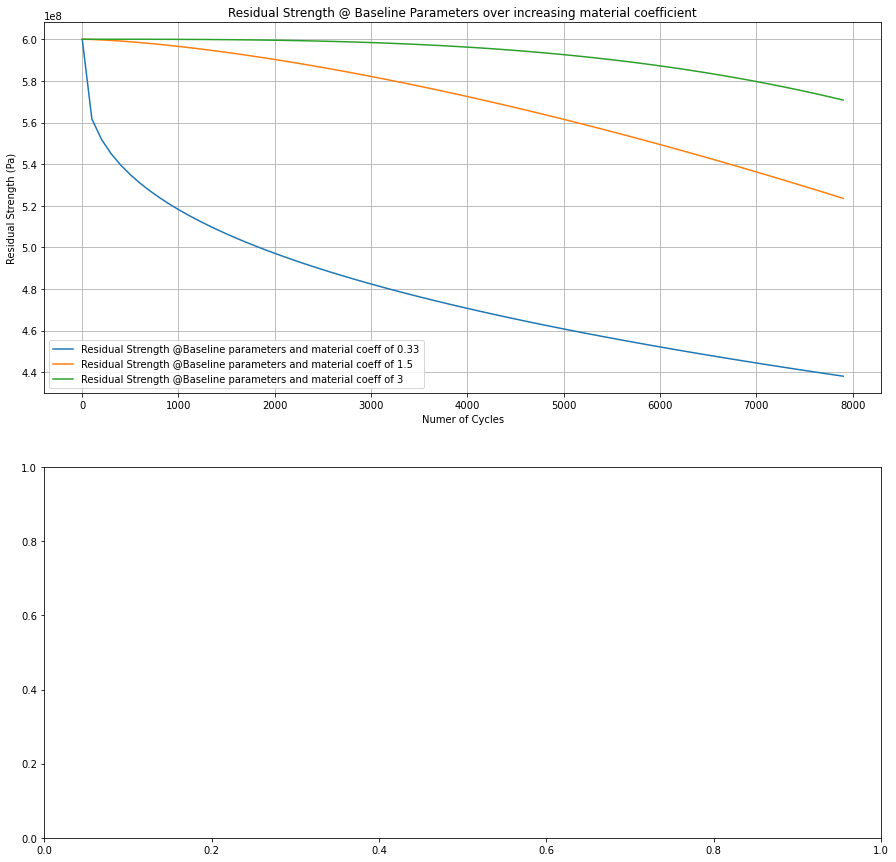

In [26]:

n_vals1 = np.arange(1, 8000, 100)
residual_strength1_vmc = strength_degradation(n_vals1, strength_original, load1, N, c1)
residual_strength2_vmc= strength_degradation(n_vals1, strength_original, load1, N, c2)
residual_strength3_vmc= strength_degradation(n_vals1, strength_original, load1, N, c3)

fig, ax = plt.subplots(2, 1, figsize=(15, 15))
ax[0].set_title('Residual Strength @ Baseline Parameters over increasing material coefficient')
ax[0].plot(figsize=(15, 15))
ax[0].plot(n_vals,residual_strength1_vmc, label= 'Residual Strength @Baseline parameters and material coeff of 0.33')
ax[0].plot(n_vals,residual_strength2_vmc, label='Residual Strength @Baseline parameters and material coeff of 1.5')
ax[0].plot(n_vals,residual_strength3_vmc,label='Residual Strength @Baseline parameters and material coeff of 3')
ax[0].set_xlabel('Numer of Cycles')
ax[0].set_ylabel('Residual Strength (Pa)')
ax[0].legend()
ax[0].grid(True)


ax1.set_title('Reliability @ Baseline Parameters over increasing fatigue life')
ax1.plot(n_vals, R_n_vals1_vN, label='Reliability @Baseline parameters and fatigue life of 15000')
ax1.plot(n_vals, R_n_vals2_vN, label='Reliability @Baseline parameters and fatigue life of 20000')
ax1.plot(n_vals, R_n_vals3_vN, label='Reliability @Baseline parameters and fatigue life of 30000')
ax1.set_xlabel('Number of Cycles')
ax1.set_ylabel('Reliability')
ax1.legend()
ax1.grid(True)


In [27]:
initial_guess = [1000, 500]
result_vmc1 = sciopt.minimize(fun=normal_log_likelihood, x0=initial_guess, args=(residual_strength1_vmc,), method='Nelder-Mead')
result_vmc2 = sciopt.minimize(fun=normal_log_likelihood, x0=initial_guess, args=(residual_strength2_vmc,), method='Nelder-Mead')
result_vmc3 = sciopt.minimize(fun=normal_log_likelihood, x0=initial_guess, args=(residual_strength3_vmc,), method='Nelder-Mead')


mean_vmc1 = result_vmc1['x'][0]
std_vmc1 = result_vmc1['x'][1]
print('aterial coeff of 0.33',mean_vmc1)
print('aterial coeff of 0.33 ',std_vmc1)

mean_vmc2 = result_vmc2['x'][0]
std_vmc2 = result_vmc2['x'][1]
print('aterial coeff of 0.5 ',mean_vmc2)
print('aterial coeff of 0.5 ',std_vmc2)

mean_vmc3 = result_vmc3['x'][0]
std_vmc3 = result_vmc3['x'][1]
print('aterial coeff of 1.5',mean_vmc3)
print('aterial coeff of 1.5',std_vmc3)

aterial coeff of 0.33 478943881.4528421
aterial coeff of 0.33  33035719.6639192
aterial coeff of 0.5  569326049.680166
aterial coeff of 0.5  23204674.176481105
aterial coeff of 1.5 592603259.3384163
aterial coeff of 1.5 8432987.91535893


## Residual Strength by Varying Fatigue Life

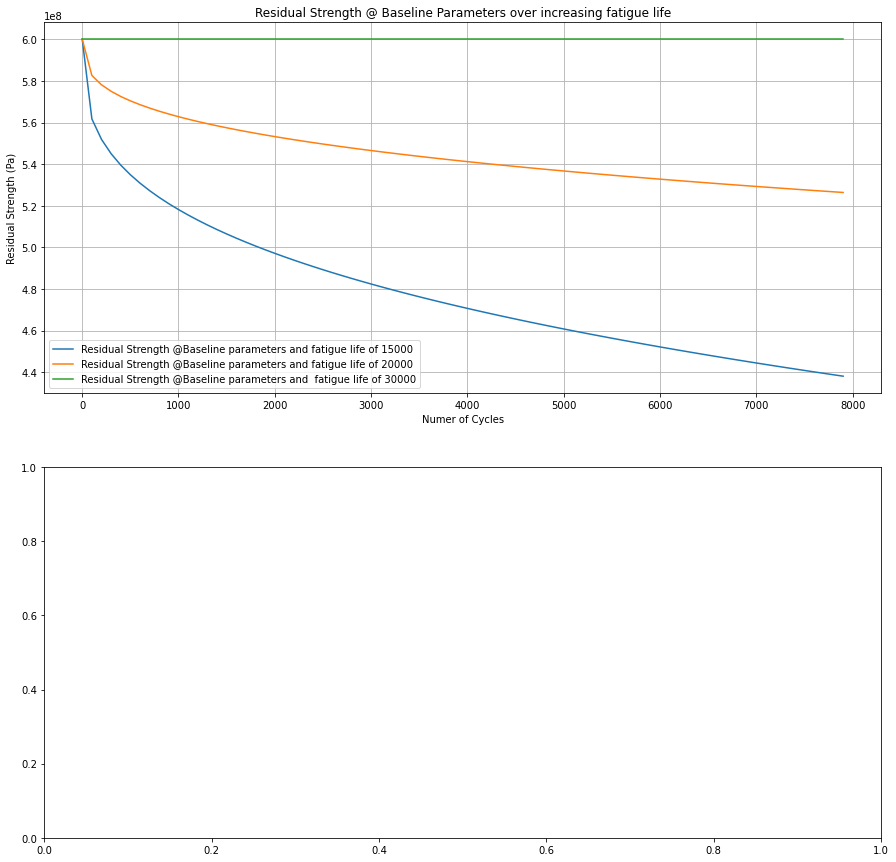

In [28]:
residual_strength1_vN = strength_degradation(n_vals, strength_original, load1, N1, c1)
residual_strength2_vN= strength_degradation(n_vals, strength_original, load2, N2, c1)
residual_strength3_vN= strength_degradation(n_vals, strength_original, load3, N3, c1)

fig, ax = plt.subplots(2, 1, figsize=(15, 15))
ax[0].set_title('Residual Strength @ Baseline Parameters over increasing fatigue life')
ax[0].plot(figsize=(15, 15))
ax[0].plot(n_vals,residual_strength1_vN, label= 'Residual Strength @Baseline parameters and fatigue life of 15000')
ax[0].plot(n_vals,residual_strength2_vN, label='Residual Strength @Baseline parameters and fatigue life of 20000')
ax[0].plot(n_vals,residual_strength3_vN,label='Residual Strength @Baseline parameters and  fatigue life of 30000')
ax[0].set_xlabel('Numer of Cycles')
ax[0].set_ylabel('Residual Strength (Pa)')
ax[0].legend()
ax[0].grid(True)

In [29]:
initial_guess = [1000, 500]
result_vN1 = sciopt.minimize(fun=normal_log_likelihood, x0=initial_guess, args=(residual_strength1_vN,), method='Nelder-Mead')
result_vN2 = sciopt.minimize(fun=normal_log_likelihood, x0=initial_guess, args=(residual_strength2_vN,), method='Nelder-Mead')
result_vN3 = sciopt.minimize(fun=normal_log_likelihood, x0=initial_guess, args=(residual_strength3_vN,), method='Nelder-Mead')


mean_vN1 = result_vN1['x'][0]
std_vN1 = result_vN1['x'][1]
print('fatigue life of 15000',mean_vN1)
print('fatigue life of 15000 ',std_vN1)

mean_vN2 = result_vN2['x'][0]
std_vN2 = result_vN2['x'][1]
print('fatigue life of 20000 ',mean_vN2)
print('fatigue life of 20000 ',std_vN2)

mean_vN3 = result_vN3['x'][0]
std_vN3 = result_vN3['x'][1]
print('fatigue life of 30000',mean_vN3)
print('fatigue life of 30000',std_vN3)

fatigue life of 15000 478943881.4528421
fatigue life of 15000  33035719.6639192
fatigue life of 20000  544953847.5867572
fatigue life of 20000  15021869.635578152
fatigue life of 30000 599999999.9998374
fatigue life of 30000 0.0002632242559653889


## Cost Model @Varying Number Load Cycles

Optimal Replacement Cycle 4401 Cycles
Optimal Replacement Cost 4.710508425227545 Rands/Cycle
Optimal Replacement Cycle 4401 Cycles
Optimal Replacement Cost 4.710508425227545 Rands/Cycle
Optimal Replacement Cycle 4401 Cycles
Optimal Replacement Cost 4.710508425227545 Rands/Cycle
15% Time Interval: [2701, 6101]
15% Time Interval: [2701, 6101]
15% Time Interval: [2701, 6101]
Cost per Day @ 15% Time Interval: [5.394548199039958, 5.384980148778346]
Cost per Day @ 15% Time Interval: [5.394548199039958, 5.384980148778346]
Cost per Day @ 15% Time Interval: [5.394548199039958, 5.384980148778346]


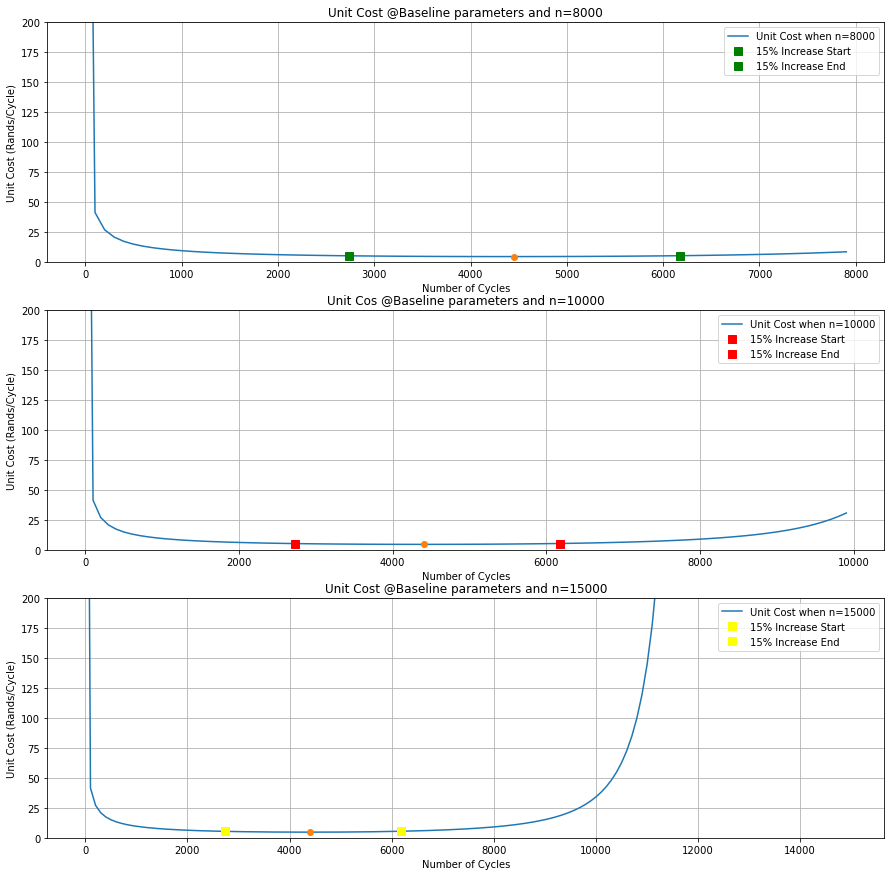

In [32]:
import scipy.integrate as scint
Cc = 60000
Cp = 650

n_vals1 = np.arange(1, 8000, 100)
n_vals2 = np.arange(1, 10000, 100)
n_vals3 = np.arange(1, 15000, 100)


tc1 = []
tc2 = []
tc3 = []

def  integrand1(t):
    return t*scistat.norm.pdf(t, loc=mean_c1, scale=std_c1)

def  integrand2(t):
    return t*scistat.norm.pdf(t, loc=mean_c2, scale=std_c2)


def  integrand3(t):
    return t*scistat.norm.pdf(t, loc=mean_c3, scale=std_c2)



for i in range(len(n_vals1)):
    int1, error = scint.quad(integrand1, 0,n_vals1[i])
    tc1.append(int1)

for i in range(len(n_vals2)):
    int2, error1 = scint.quad(integrand2, 0,n_vals2[i])
    tc2.append(int2)

for i in range(len(n_vals3)):
    int3, error2 = scint.quad(integrand3, 0,n_vals3[i])
    tc3.append(int3)

array1=np.array(R_n_vals1)
array2=np.array(R_n_vals2)
array3=np.array(R_n_vals3)
# print(len(tc3))
tc1=np.array(tc1)/(1-array1)
tc2=np.array(tc2)/(1-array2)
tc3=np.array(tc3)/(1-array3)


Le1 = ((n_vals1) * array1) + (tc1) * (1 - array1)
Le2 = ((n_vals2) * array2) + (tc2) * (1 - array2)
Le3 = ((n_vals3) * array3) + (tc3) * (1 - array3)


C1 = Cp * array1 + Cc * (1 - array1)
C2 = Cp * array2 + Cc * (1 - array2)
C3 = Cp * array3 + Cc * (1 - array3)

Cph1 = C1 / Le1
Cph2 = C2 / Le2
Cph3 = C3 / Le3


idx_min = np.argmin(Cph1)
xmin1 = n_vals1[idx_min]
ymin1 = np.nanmin(Cph1)
print('Optimal Replacement Cycle',xmin1,'Cycles')
print('Optimal Replacement Cost',ymin1,'Rands/Cycle')


idx_min1 = np.argmin(Cph2)
xmin2 = n_vals2[idx_min1]
ymin2 = np.nanmin(Cph2)
print('Optimal Replacement Cycle',xmin2,'Cycles')
print('Optimal Replacement Cost',ymin2,'Rands/Cycle')

idx_min2 = np.argmin(Cph3)
xmin3 = n_vals3[idx_min2]
ymin3 = np.nanmin(Cph3)
print('Optimal Replacement Cycle',xmin3,'Cycles')
print('Optimal Replacement Cost',ymin3,'Rands/Cycle')

x1=ymin1*1.15
x2=ymin2*1.15
x3=ymin3*1.15


indices_within_5_percent1 = np.where((Cph1 >= ymin1) & (Cph1 <= x1))[0]
indices_within_5_percent2 = np.where((Cph2 >= ymin2) & (Cph2 <= x2))[0]
indices_within_5_percent3 = np.where((Cph3 >= ymin3) & (Cph3 <= x3))[0]

print("15% Time Interval:", [n_vals1[indices_within_5_percent1[0]], n_vals1[indices_within_5_percent1[-1]]])
print("15% Time Interval:", [n_vals2[indices_within_5_percent2[0]], n_vals2[indices_within_5_percent2[-1]]])
print("15% Time Interval:", [n_vals3[indices_within_5_percent3[0]], n_vals3[indices_within_5_percent3[-1]]])

print("Cost per Day @ 15% Time Interval:", [Cph1[indices_within_5_percent1[0]], Cph1[indices_within_5_percent1[-1]]])
print("Cost per Day @ 15% Time Interval:", [Cph2[indices_within_5_percent2[0]], Cph2[indices_within_5_percent2[-1]]])
print("Cost per Day @ 15% Time Interval:", [Cph3[indices_within_5_percent3[0]], Cph3[indices_within_5_percent3[-1]]])
# # Cph_c=C2/Le
# # Cph_c=C2/Le
fig, ax = plt.subplots(3, 1, figsize=(15, 15))

ax[0].set_title('Unit Cost @Baseline parameters and n=8000')
ax[0].plot(n_vals1, Cph1, label='Unit Cost when n=8000')
ax[0].plot(xmin, ymin, 'o')
ax[0].plot(tp[indices_within_5_percent1[0]], Cph1[indices_within_5_percent1[0]], 's', color='green', markersize=8, label='15% Increase Start')
ax[0].plot(tp[indices_within_5_percent1[-1]], Cph1[indices_within_5_percent1[-1]], 's', color='green', markersize=8, label='15% Increase End')

ax[0].set_xlabel('Number of Cycles')
ax[0].set_ylabel('Unit Cost (Rands/Cycle)')
ax[0].legend()
ax[0].set_ylim(0,200)
ax[0].grid(True)

ax[1].set_title('Unit Cos @Baseline parameters and n=10000')
ax[1].plot(n_vals2, Cph2, label='Unit Cost when n=10000')
ax[1].plot(xmin1, ymin1, 'o')
ax[1].plot(tp[indices_within_5_percent2[0]], Cph2[indices_within_5_percent2[0]], 's', color='red', markersize=8, label='15% Increase Start')
ax[1].plot(tp[indices_within_5_percent2[-1]], Cph2[indices_within_5_percent2[-1]], 's', color='red', markersize=8, label='15% Increase End')

ax[1].set_xlabel('Number of Cycles')
ax[1].set_ylabel('Unit Cost (Rands/Cycle)')
ax[1].set_ylim(0,200)
ax[1].legend()
ax[1].grid(True)

ax[2].set_title('Unit Cost @Baseline parameters and n=15000')
ax[2].plot(n_vals3, Cph3, label='Unit Cost when n=15000')
ax[2].plot(xmin2, ymin2, 'o')
ax[2].plot(tp[indices_within_5_percent3[0]], Cph3[indices_within_5_percent3[0]], 's', color='yellow', markersize=8, label='15% Increase Start')
ax[2].plot(tp[indices_within_5_percent3[-1]], Cph3[indices_within_5_percent3[-1]], 's', color='yellow', markersize=8, label='15% Increase End')

ax[2].set_xlabel('Number of Cycles')
ax[2].set_ylabel('Unit Cost (Rands/Cycle)')
ax[2].legend()
ax[2].set_ylim(0,200)
ax[2].grid(True)





## Cost Model @Varying Magnitude of Load

Optimal Replacement Cycle 4401 Cycles
Optimal Replacement Cost 4.710508425227545 Rands/Cycle
Optimal Replacement Cycle 3401 Cycles
Optimal Replacement Cost 208.78140739646273 Rands/Cycle
Optimal Replacement Cycle 101 Cycles
Optimal Replacement Cost 60076.599048566306 Rands/Cycle
15% Time Interval: [2701, 6101]
15% Time Interval: [2001, 4801]
15% Time Interval: [1, 1601]
Cost per Day @ 15% Time Interval: [5.394548199039958, 5.384980148778346]
Cost per Day @ 15% Time Interval: [235.51885197086557, 235.88233701687074]
Cost per Day @ 15% Time Interval: [60650.06790794128, 68606.20214692074]


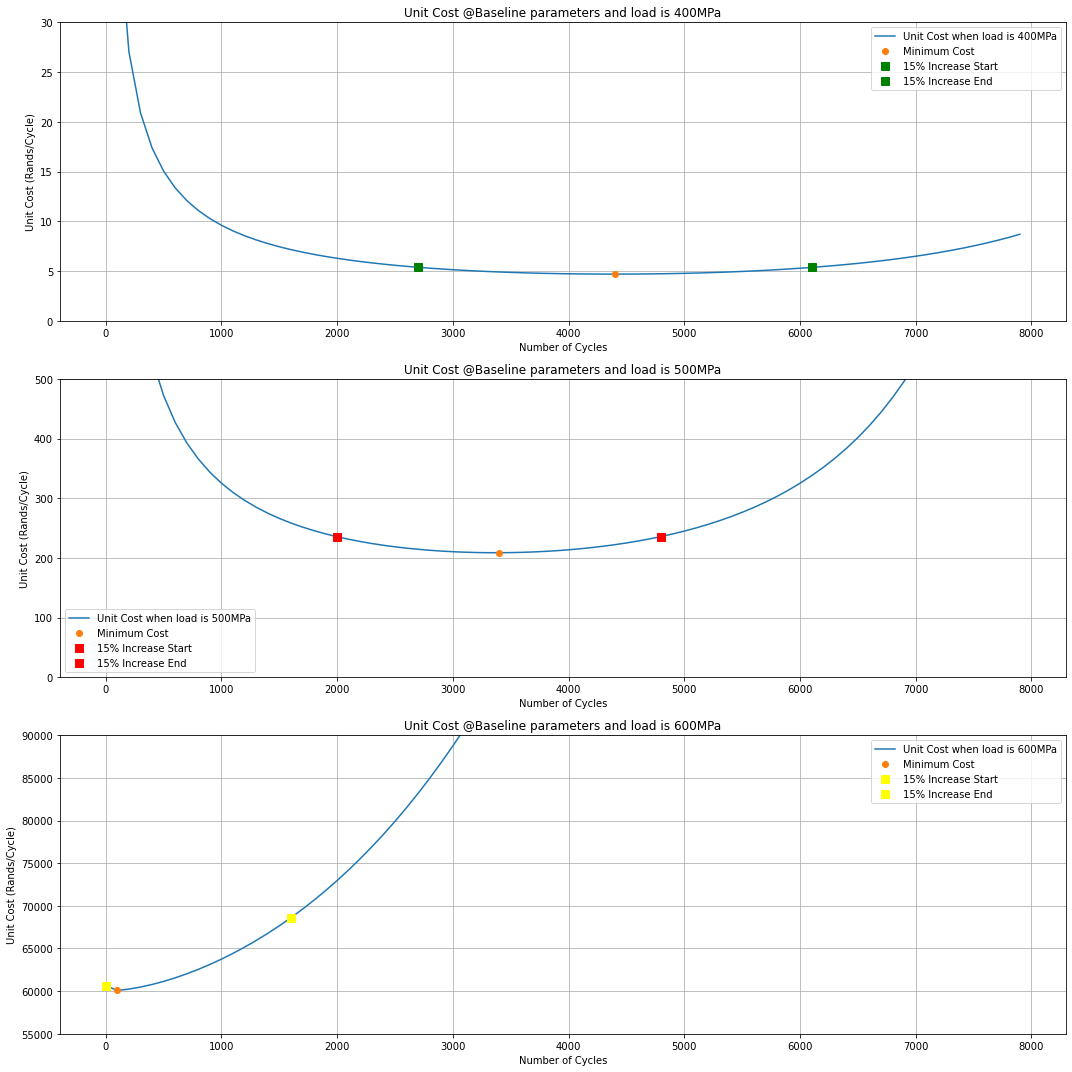

In [34]:
import scipy.integrate as scint
Cc = 60000
Cp = 650

n_vals1 = np.arange(1, 8000, 100)
n_vals2 = np.arange(1, 10000, 100)
n_vals3 = np.arange(1, 15000, 100)


tc1 = []
tc2 = []
tc3 = []

def  integrand1(t):
    return t*scistat.norm.pdf(t, loc=mean_vl1, scale=std_vl1)

def  integrand2(t):
    return t*scistat.norm.pdf(t, loc=std_vl2, scale=std_vl2)


def  integrand3(t):
    return t*scistat.norm.pdf(t, loc=std_vl2, scale=std_vl2)



for i in range(len(n_vals1)):
    int1, error = scint.quad(integrand1, 0,n_vals1[i])
    tc1.append(int1)

for i in range(len(n_vals1)):
    int2, error1 = scint.quad(integrand2, 0,n_vals2[i])
    tc2.append(int2)

for i in range(len(n_vals1)):
    int3, error2 = scint.quad(integrand3, 0,n_vals3[i])
    tc3.append(int3)

    
# R_n_vals1_vl = []
# h_n_vals1_vl = []
# R_n_vals2_vl = []
# h_n_vals2_vl = []
# R_n_vals3_vl = []
# h_n_vals3_vl = []
array1_vl=np.array(R_n_vals1_vl)
array2_vl=np.array(R_n_vals2_vl)
array3_vl=np.array(R_n_vals3_vl)
# print(len(tc3))
tc1=np.array(tc1)/(1-array1_vl)
tc2=np.array(tc2)/(1-array2_vl)
tc3=np.array(tc3)/(1-array3_vl)


Le1_vl = ((n_vals1) * array1_vl) + (tc1) * (1 - array1_vl)
Le2_vl = ((n_vals1) * array2_vl) + (tc2) * (1 - array2_vl)
Le3_vl = ((n_vals1) * array3_vl) + (tc3) * (1 - array3_vl)


C1_vl = Cp * array1_vl + Cc * (1 - array1_vl)
C2_vl = Cp * array2_vl + Cc * (1 - array2_vl)
C3_vl = Cp * array3_vl + Cc * (1 - array3_vl)

Cph1_vl = C1_vl / Le1_vl
Cph2_vl = C2_vl / Le2_vl
Cph3_vl = C3_vl / Le3_vl


idx_min_vl = np.argmin(Cph1_vl)
xmin1_vl = n_vals1[idx_min_vl]
ymin1_vl = np.nanmin(Cph1_vl)
print('Optimal Replacement Cycle',xmin1_vl,'Cycles')
print('Optimal Replacement Cost',ymin1_vl,'Rands/Cycle')


idx_min1_vl = np.argmin(Cph2_vl)
xmin2_vl = n_vals1[idx_min1_vl]
ymin2_vl = np.nanmin(Cph2_vl)
print('Optimal Replacement Cycle',xmin2_vl,'Cycles')
print('Optimal Replacement Cost',ymin2_vl,'Rands/Cycle')

idx_min2_vl = np.argmin(Cph3_vl)
xmin3_vl = n_vals1[idx_min2_vl]
ymin3_vl = np.nanmin(Cph3_vl)
print('Optimal Replacement Cycle',xmin3_vl,'Cycles')
print('Optimal Replacement Cost',ymin3_vl,'Rands/Cycle')

x1_vl=ymin1_vl*1.15
x2_vl=ymin2_vl*1.15
x3_vl=ymin3_vl*1.15


indices_within_5_percent1_vl = np.where((Cph1_vl >= ymin1_vl) & (Cph1_vl <= x1_vl))[0]
indices_within_5_percent2_vl = np.where((Cph2_vl >= ymin2_vl) & (Cph2_vl <= x2_vl))[0]
indices_within_5_percent3_vl = np.where((Cph3_vl >= ymin3_vl) & (Cph3_vl <= x3_vl))[0]

print("15% Time Interval:", [n_vals1[indices_within_5_percent1_vl[0]], n_vals1[indices_within_5_percent1_vl[-1]]])
print("15% Time Interval:", [n_vals1[indices_within_5_percent2_vl[0]], n_vals1[indices_within_5_percent2_vl[-1]]])
print("15% Time Interval:", [n_vals1[indices_within_5_percent3_vl[0]], n_vals1[indices_within_5_percent3_vl[-1]]])

print("Cost per Day @ 15% Time Interval:", [Cph1_vl[indices_within_5_percent1_vl[0]], Cph1_vl[indices_within_5_percent1_vl[-1]]])
print("Cost per Day @ 15% Time Interval:", [Cph2_vl[indices_within_5_percent2_vl[0]], Cph2_vl[indices_within_5_percent2_vl[-1]]])
print("Cost per Day @ 15% Time Interval:", [Cph3_vl[indices_within_5_percent3_vl[0]], Cph3_vl[indices_within_5_percent3_vl[-1]]])

fig, ax = plt.subplots(3, 1, figsize=(15, 15))

ax[0].plot(n_vals1, Cph1_vl, label='Unit Cost when load is 400MPa')
ax[0].plot(xmin1_vl, ymin1_vl, 'o', label='Minimum Cost')
ax[0].plot(n_vals1[indices_within_5_percent1_vl[0]], Cph1_vl[indices_within_5_percent1_vl[0]], 's', color='green', markersize=8, label='15% Increase Start')
ax[0].plot(n_vals1[indices_within_5_percent1_vl[-1]], Cph1_vl[indices_within_5_percent1_vl[-1]], 's', color='green', markersize=8, label='15% Increase End')
ax[0].set_title('Unit Cost @Baseline parameters and load is 400MPa')
ax[0].set_xlabel('Number of Cycles')
ax[0].set_ylabel('Unit Cost (Rands/Cycle)')
ax[0].set_ylim(0,30)
ax[0].legend()
ax[0].grid(True)

ax[1].plot(n_vals1, Cph2_vl, label='Unit Cost when load is 500MPa')
ax[1].plot(xmin2_vl, ymin2_vl, 'o', label='Minimum Cost')
ax[1].plot(n_vals1[indices_within_5_percent2_vl[0]], Cph2_vl[indices_within_5_percent2_vl[0]], 's', color='red', markersize=8, label='15% Increase Start')
ax[1].plot(n_vals1[indices_within_5_percent2_vl[-1]], Cph2_vl[indices_within_5_percent2_vl[-1]], 's', color='red', markersize=8, label='15% Increase End')
ax[1].set_title('Unit Cost @Baseline parameters and load is 500MPa')
ax[1].set_xlabel('Number of Cycles')
ax[1].set_ylabel('Unit Cost (Rands/Cycle)')
ax[1].set_ylim(0,500)
ax[1].legend()
ax[1].grid(True)

ax[2].plot(n_vals1, Cph3_vl, label='Unit Cost when load is 600MPa')
ax[2].plot(xmin3_vl, ymin3_vl, 'o', label='Minimum Cost')
ax[2].plot(n_vals1[indices_within_5_percent3_vl[0]], Cph3_vl[indices_within_5_percent3_vl[0]], 's', color='yellow', markersize=8, label='15% Increase Start')
ax[2].plot(n_vals1[indices_within_5_percent3_vl[-1]], Cph3_vl[indices_within_5_percent3_vl[-1]], 's', color='yellow', markersize=8, label='15% Increase End')
ax[2].set_title('Unit Cost @Baseline parameters and load is 600MPa')
ax[2].set_xlabel('Number of Cycles')
ax[2].set_ylabel('Unit Cost (Rands/Cycle)')
ax[2].set_ylim(55000,90000)
ax[2].legend()
ax[2].grid(True)

plt.tight_layout()
plt.show()

## Cost Model @Varying Material Coeffcient

Optimal Replacement Cycle 501 Cycles
Optimal Replacement Cost 50.507082840992915 Rands/Cycle
Optimal Replacement Cycle 4401 Cycles
Optimal Replacement Cost 4.710364148571607 Rands/Cycle
Optimal Replacement Cycle 7401 Cycles
Optimal Replacement Cost 2.700589775999492 Rands/Cycle
15% Time Interval: [201, 1001]
15% Time Interval: [2701, 6101]
15% Time Interval: [5201, 7901]
Cost per Day @ 15% Time Interval: [57.90745336600607, 56.2000835697537]
Cost per Day @ 15% Time Interval: [5.394454598608145, 5.384716882781489]
Cost per Day @ 15% Time Interval: [3.0763130327072203, 2.7209392503162935]


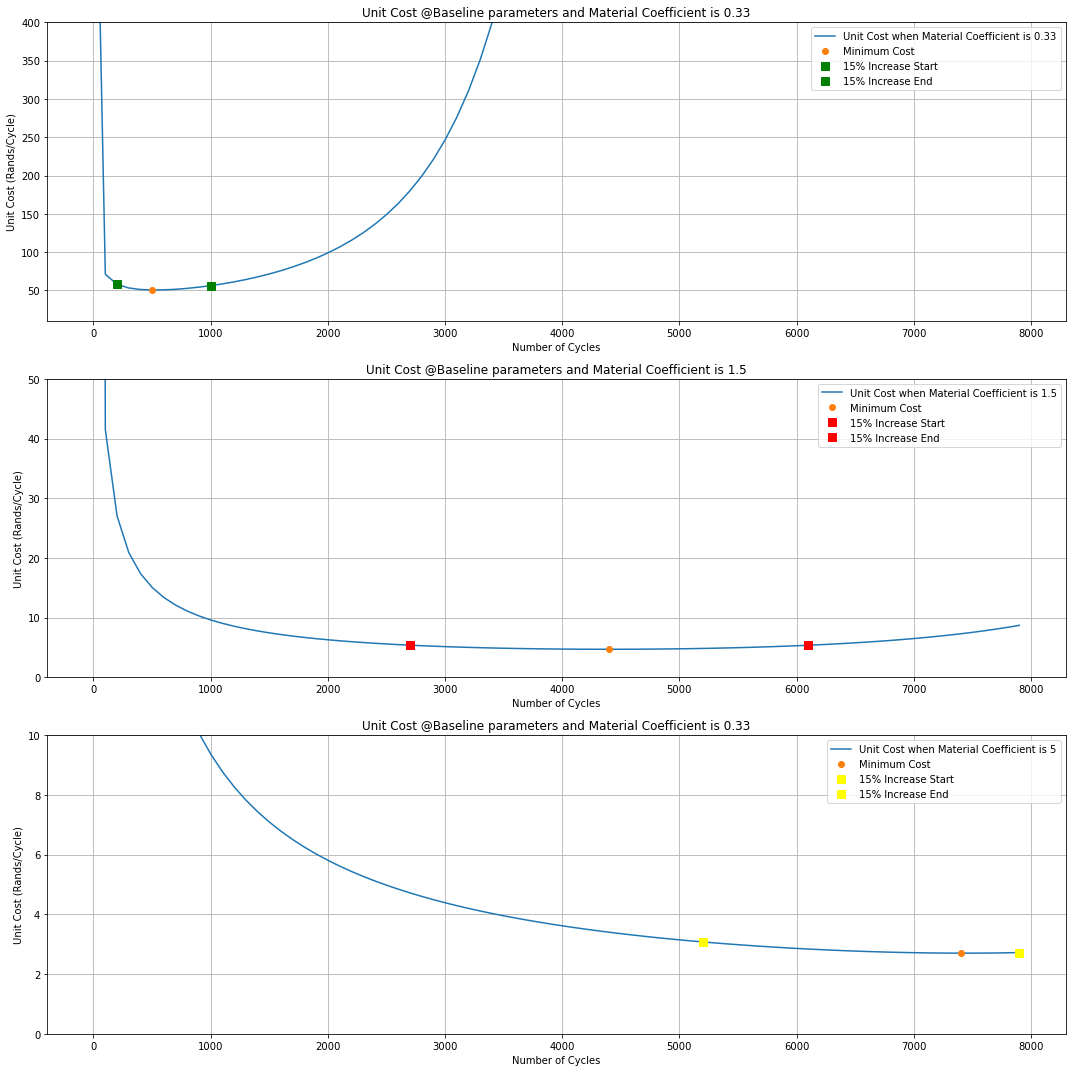

In [35]:
import scipy.integrate as scint
Cc = 60000
Cp = 650

n_vals1 = np.arange(1, 8000, 100)
n_vals2 = np.arange(1, 10000, 100)
n_vals3 = np.arange(1, 15000, 100)


tc1 = []
tc2 = []
tc3 = []

def  integrand1(t):
    return t*scistat.norm.pdf(t, loc=mean_vmc1, scale=std_vmc1)

def  integrand2(t):
    return t*scistat.norm.pdf(t, loc=std_vmc2, scale=std_vmc2)


def  integrand3(t):
    return t*scistat.norm.pdf(t, loc=std_vmc3, scale=std_vmc3)



for i in range(len(n_vals1)):
    int1, error = scint.quad(integrand1, 0,n_vals1[i])
    tc1.append(int1)

for i in range(len(n_vals1)):
    int2, error1 = scint.quad(integrand2, 0,n_vals1[i])
    tc2.append(int2)

for i in range(len(n_vals1)):
    int3, error2 = scint.quad(integrand3, 0,n_vals1[i])
    tc3.append(int3)

    
# R_n_vals1_vl = []
# h_n_vals1_vl = []
# R_n_vals2_vl = []
# h_n_vals2_vl = []
# R_n_vals3_vl = []
# h_n_vals3_vl = []
array1_vmc=np.array(R_n_vals1_vc)
array2_vmc=np.array(R_n_vals2_vc)
array3_vmc=np.array(R_n_vals3_vc)
# print(len(tc3))
tc1_vmc=np.array(tc1)/(1-array1_vmc)
tc2_vmc=np.array(tc2)/(1-array2_vmc)
tc3_vmc=np.array(tc3)/(1-array3_vmc)


Le1_vmc = ((n_vals1) * array1_vmc) + (tc1_vmc) * (1 - array1_vmc)
Le2_vmc = ((n_vals1) * array2_vmc) + (tc2_vmc) * (1 - array2_vmc)
Le3_vmc = ((n_vals1) * array3_vmc) + (tc3_vmc) * (1 - array3_vmc)


C1_vmc= Cp * array1_vmc + Cc * (1 - array1_vmc)
C2_vmc = Cp * array2_vmc + Cc * (1 - array2_vmc)
C3_vmc = Cp * array3_vmc + Cc * (1 - array3_vmc)

Cph1_vmc = C1_vmc / Le1_vmc
Cph2_vmc = C2_vmc / Le2_vmc
Cph3_vmc = C3_vmc / Le3_vmc


idx_min_vmc = np.argmin(Cph1_vmc)
xmin1_vmc = n_vals1[idx_min_vmc]
ymin1_vmc = np.nanmin(Cph1_vmc)
print('Optimal Replacement Cycle',xmin1_vmc,'Cycles')
print('Optimal Replacement Cost',ymin1_vmc,'Rands/Cycle')


idx_min1_vmc = np.argmin(Cph2_vmc)
xmin2_vmc = n_vals1[idx_min1_vmc]
ymin2_vmc = np.nanmin(Cph2_vmc)
print('Optimal Replacement Cycle',xmin2_vmc,'Cycles')
print('Optimal Replacement Cost',ymin2_vmc,'Rands/Cycle')

idx_min2_vmc = np.argmin(Cph3_vmc)
xmin3_vmc = n_vals1[idx_min2_vmc]
ymin3_vmc = np.nanmin(Cph3_vmc)
print('Optimal Replacement Cycle',xmin3_vmc,'Cycles')
print('Optimal Replacement Cost',ymin3_vmc,'Rands/Cycle')

x1_vmc=ymin1_vmc*1.15
x2_vmc=ymin2_vmc*1.15
x3_vmc=ymin3_vmc*1.15


indices_within_5_percent1_vmc = np.where((Cph1_vmc >= ymin1_vmc) & (Cph1_vmc <= x1_vmc))[0]
indices_within_5_percent2_vmc = np.where((Cph2_vmc >= ymin2_vmc) & (Cph2_vmc <= x2_vmc))[0]
indices_within_5_percent3_vmc= np.where((Cph3_vmc >= ymin3_vmc) & (Cph3_vmc <= x3_vmc))[0]

print("15% Time Interval:", [n_vals1[indices_within_5_percent1_vmc[0]], n_vals1[indices_within_5_percent1_vmc[-1]]])
print("15% Time Interval:", [n_vals1[indices_within_5_percent2_vmc[0]], n_vals1[indices_within_5_percent2_vmc[-1]]])
print("15% Time Interval:", [n_vals1[indices_within_5_percent3_vmc[0]], n_vals1[indices_within_5_percent3_vmc[-1]]])

print("Cost per Day @ 15% Time Interval:", [Cph1_vmc[indices_within_5_percent1_vmc[0]], Cph1_vmc[indices_within_5_percent1_vmc[-1]]])
print("Cost per Day @ 15% Time Interval:", [Cph2_vmc[indices_within_5_percent2_vmc[0]], Cph2_vmc[indices_within_5_percent2_vmc[-1]]])
print("Cost per Day @ 15% Time Interval:", [Cph3_vmc[indices_within_5_percent3_vmc[0]], Cph3_vmc[indices_within_5_percent3_vmc[-1]]])

fig, ax = plt.subplots(3, 1, figsize=(15, 15))

ax[0].plot(n_vals1, Cph1_vmc, label='Unit Cost when Material Coefficient is 0.33')
ax[0].plot(xmin1_vmc, ymin1_vmc, 'o', label='Minimum Cost')
ax[0].plot(n_vals1[indices_within_5_percent1_vmc[0]], Cph1_vmc[indices_within_5_percent1_vmc[0]], 's', color='green', markersize=8, label='15% Increase Start')
ax[0].plot(n_vals1[indices_within_5_percent1_vmc[-1]], Cph1_vmc[indices_within_5_percent1_vmc[-1]], 's', color='green', markersize=8, label='15% Increase End')
ax[0].set_title('Unit Cost @Baseline parameters and Material Coefficient is 0.33')
ax[0].set_xlabel('Number of Cycles')
ax[0].set_ylabel('Unit Cost (Rands/Cycle)')
ax[0].set_ylim(10,400)
ax[0].legend()
ax[0].grid(True)

ax[1].plot(n_vals1, Cph2_vmc, label='Unit Cost when Material Coefficient is 1.5')
ax[1].plot(xmin2_vmc, ymin2_vmc, 'o', label='Minimum Cost')
ax[1].plot(n_vals1[indices_within_5_percent2_vmc[0]], Cph2_vmc[indices_within_5_percent2_vmc[0]], 's', color='red', markersize=8, label='15% Increase Start')
ax[1].plot(n_vals1[indices_within_5_percent2_vmc[-1]], Cph2_vmc[indices_within_5_percent2_vmc[-1]], 's', color='red', markersize=8, label='15% Increase End')
ax[1].set_title('Unit Cost @Baseline parameters and Material Coefficient is 1.5')
ax[1].set_xlabel('Number of Cycles')
ax[1].set_ylabel('Unit Cost (Rands/Cycle)')
ax[1].set_ylim(0,50)
ax[1].legend()
ax[1].grid(True)

ax[2].plot(n_vals1, Cph3_vmc, label='Unit Cost when Material Coefficient is 5')
ax[2].plot(xmin3_vmc, ymin3_vmc, 'o', label='Minimum Cost')
ax[2].plot(n_vals1[indices_within_5_percent3_vmc[0]], Cph3_vmc[indices_within_5_percent3_vmc[0]], 's', color='yellow', markersize=8, label='15% Increase Start')
ax[2].plot(n_vals1[indices_within_5_percent3_vmc[-1]], Cph3_vmc[indices_within_5_percent3_vmc[-1]], 's', color='yellow', markersize=8, label='15% Increase End')
ax[2].set_title('Unit Cost @Baseline parameters and Material Coefficient is 0.33')
ax[2].set_xlabel('Number of Cycles')
ax[2].set_ylabel('Unit Cost (Rands/Cycle)')
ax[2].set_ylim(0,10)
ax[2].legend()
ax[2].grid(True)

plt.tight_layout()
plt.show()

## Cost Model @Varying Fatigue Life

Optimal Replacement Cycle 4401 Cycles
Optimal Replacement Cost 4.710508425227545 Rands/Cycle
Optimal Replacement Cycle 5801 Cycles
Optimal Replacement Cost 3.854537770570745 Rands/Cycle
Optimal Replacement Cycle 7901 Cycles
Optimal Replacement Cost 2.9157250725353245 Rands/Cycle
15% Time Interval: [2701, 6101]
15% Time Interval: [3601, 7901]
15% Time Interval: [5301, 7901]
Cost per Day @ 15% Time Interval: [5.394548199039958, 5.384980148778346]
Cost per Day @ 15% Time Interval: [4.406430577588758, 4.322280858444669]
Cost per Day @ 15% Time Interval: [3.3317950250563855, 2.9157250725353245]


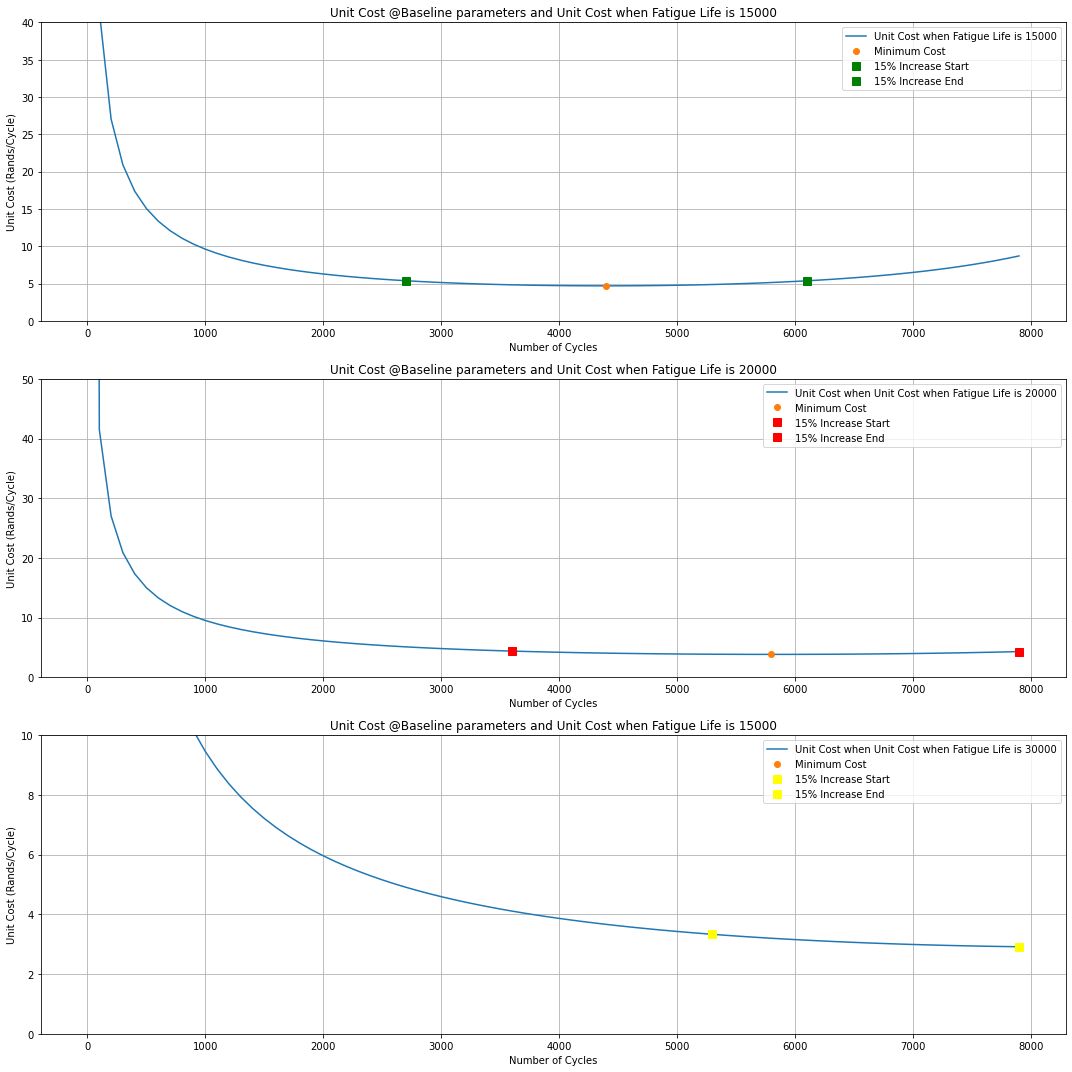

In [43]:
import scipy.integrate as scint
Cc = 60000
Cp = 650

n_vals1 = np.arange(1, 8000, 100)
n_vals2 = np.arange(1, 10000, 100)
n_vals3 = np.arange(1, 15000, 100)


tc1 = []
tc2 = []
tc3 = []

def  integrand1(t):
    return t*scistat.norm.pdf(t, loc=mean_vN1, scale=std_vN1)

def  integrand2(t):
    return t*scistat.norm.pdf(t, loc=std_vN2, scale=std_vN2)


def  integrand3(t):
    return t*scistat.norm.pdf(t, loc=std_vN3, scale=std_vN3)



for i in range(len(n_vals1)):
    int1, error = scint.quad(integrand1, 0,n_vals1[i])
    tc1.append(int1)

for i in range(len(n_vals1)):
    int2, error1 = scint.quad(integrand2, 0,n_vals1[i])
    tc2.append(int2)

for i in range(len(n_vals1)):
    int3, error2 = scint.quad(integrand3, 0,n_vals1[i])
    tc3.append(int3)


array1_vN=np.array(R_n_vals1_vN)
array2_vN=np.array(R_n_vals2_vN)
array3_vN=np.array(R_n_vals3_vN)
# print(len(tc3))
tc1_vN=np.array(tc1)/(1-array1_vN)
tc2_vN=np.array(tc2)/(1-array2_vN)
tc3_vN=np.array(tc3)/(1-array3_vN)


Le1_vN = ((n_vals1) * array1_vN) + (tc1_vN) * (1 - array1_vN)
Le2_vN = ((n_vals1) * array2_vN) + (tc2_vN) * (1 - array2_vN)
Le3_vN = ((n_vals1) * array3_vN) + (tc3_vN) * (1 - array3_vN)


C1_vN= Cp * array1_vN + Cc * (1 - array1_vN)
C2_vN = Cp * array2_vN + Cc * (1 - array2_vN)
C3_vN = Cp * array3_vN + Cc * (1 - array3_vN)

Cph1_vN = C1_vN / Le1_vN
Cph2_vN = C2_vN / Le2_vN
Cph3_vN = C3_vN / Le3_vN


idx_min_vN = np.argmin(Cph1_vN)
xmin1_vN = n_vals1[idx_min_vN]
ymin1_vN = np.nanmin(Cph1_vN)
print('Optimal Replacement Cycle',xmin1_vN,'Cycles')
print('Optimal Replacement Cost',ymin1_vN,'Rands/Cycle')


idx_min1_vN = np.argmin(Cph2_vN)
xmin2_vN = n_vals1[idx_min1_vN]
ymin2_vN = np.nanmin(Cph2_vN)
print('Optimal Replacement Cycle',xmin2_vN,'Cycles')
print('Optimal Replacement Cost',ymin2_vN,'Rands/Cycle')

idx_min2_vN = np.argmin(Cph3_vN)
xmin3_vN = n_vals1[idx_min2_vN]
ymin3_vN = np.nanmin(Cph3_vN)
print('Optimal Replacement Cycle',xmin3_vN,'Cycles')
print('Optimal Replacement Cost',ymin3_vN,'Rands/Cycle')

x1_vN=ymin1_vN*1.15
x2_vN=ymin2_vN*1.15
x3_vN=ymin3_vN*1.15


indices_within_5_percent1_vN = np.where((Cph1_vN >= ymin1_vN) & (Cph1_vN <= x1_vN))[0]
indices_within_5_percent2_vN = np.where((Cph2_vN >= ymin2_vN) & (Cph2_vN <= x2_vN))[0]
indices_within_5_percent3_vN= np.where((Cph3_vN >= ymin3_vN) & (Cph3_vN <= x3_vN))[0]

print("15% Time Interval:", [n_vals1[indices_within_5_percent1_vN[0]], n_vals1[indices_within_5_percent1_vN[-1]]])
print("15% Time Interval:", [n_vals1[indices_within_5_percent2_vN[0]], n_vals1[indices_within_5_percent2_vN[-1]]])
print("15% Time Interval:", [n_vals1[indices_within_5_percent3_vN[0]], n_vals1[indices_within_5_percent3_vN[-1]]])

print("Cost per Day @ 15% Time Interval:", [Cph1_vN[indices_within_5_percent1_vN[0]], Cph1_vN[indices_within_5_percent1_vN[-1]]])
print("Cost per Day @ 15% Time Interval:", [Cph2_vN[indices_within_5_percent2_vN[0]], Cph2_vN[indices_within_5_percent2_vN[-1]]])
print("Cost per Day @ 15% Time Interval:", [Cph3_vN[indices_within_5_percent3_vN[0]], Cph3_vN[indices_within_5_percent3_vN[-1]]])

fig, ax = plt.subplots(3, 1, figsize=(15, 15))

ax[0].plot(n_vals1, Cph1_vN, label='Unit Cost when Fatigue Life is 15000')
ax[0].plot(xmin1_vN, ymin1_vN, 'o', label='Minimum Cost')
ax[0].plot(n_vals1[indices_within_5_percent1_vN[0]], Cph1_vN[indices_within_5_percent1_vN[0]], 's', color='green', markersize=8, label='15% Increase Start')
ax[0].plot(n_vals1[indices_within_5_percent1_vN[-1]], Cph1_vN[indices_within_5_percent1_vN[-1]], 's', color='green', markersize=8, label='15% Increase End')
ax[0].set_title('Unit Cost @Baseline parameters and Unit Cost when Fatigue Life is 15000')
ax[0].set_xlabel('Number of Cycles')
ax[0].set_ylabel('Unit Cost (Rands/Cycle)')
ax[0].set_ylim(0,40)
ax[0].legend()
ax[0].grid(True)

ax[1].plot(n_vals1, Cph2_vN, label='Unit Cost when Unit Cost when Fatigue Life is 20000')
ax[1].plot(xmin2_vN, ymin2_vN, 'o', label='Minimum Cost')
ax[1].plot(n_vals1[indices_within_5_percent2_vN[0]], Cph2_vN[indices_within_5_percent2_vN[0]], 's', color='red', markersize=8, label='15% Increase Start')
ax[1].plot(n_vals1[indices_within_5_percent2_vN[-1]], Cph2_vN[indices_within_5_percent2_vN[-1]], 's', color='red', markersize=8, label='15% Increase End')
ax[1].set_title('Unit Cost @Baseline parameters and Unit Cost when Fatigue Life is 20000')
ax[1].set_xlabel('Number of Cycles')
ax[1].set_ylabel('Unit Cost (Rands/Cycle)')
ax[1].set_ylim(0,50)
ax[1].legend()
ax[1].grid(True)

ax[2].plot(n_vals1, Cph3_vN, label='Unit Cost when Unit Cost when Fatigue Life is 30000')
ax[2].plot(xmin3_vN, ymin3_vN, 'o', label='Minimum Cost')
ax[2].plot(n_vals1[indices_within_5_percent3_vN[0]], Cph3_vN[indices_within_5_percent3_vN[0]], 's', color='yellow', markersize=8, label='15% Increase Start')
ax[2].plot(n_vals1[indices_within_5_percent3_vN[-1]], Cph3_vN[indices_within_5_percent3_vN[-1]], 's', color='yellow', markersize=8, label='15% Increase End')
ax[2].set_title('Unit Cost @Baseline parameters and Unit Cost when Fatigue Life is 30000')
ax[2].set_xlabel('Number of Cycles')
ax[2].set_ylabel('Unit Cost (Rands/Cycle)')
ax[2].set_ylim(0,10)
ax[2].legend()
ax[2].grid(True)

plt.tight_layout()
plt.show()

## Cost Model @ Baseline Parameters Varying Preventive Cost

Optimal Replacement Cycle when Cp=R650 4401 Cycles
Optimal Replacement Cost when Cp=R650 4.710508425227545 Rands/Cycle
Optimal Replacement Cycle when Cp=R5000 4801 Cycles
Optimal Replacement Cost when Cp=R5000 5.651921166536627 Rands/Cycle
Optimal Replacement Cycle when Cp=R20000 5701 Cycles
Optimal Replacement Cost when Cp=R20000 8.484985563694133 Rands/Cycle
Optimal Replacement Cycle when Cc=R60000 4401 Cycles
Optimal Replacement Cost when Cc=R60000 4.710508425227545 Rands/Cycle
Optimal Replacement Cycle when Cc=R100000 4601 Cycles
Optimal Replacement Cost when Cc=R100000 8.717425683148278 Rands/Cycle
Optimal Replacement Cycle when Cc=R150000 5101 Cycles
Optimal Replacement Cost when Cc=R150000 15.646867500731522 Rands/Cycle
15% Time Interval: [2701, 6101]
15% Time Interval: [3101, 6501]
15% Time Interval: [3901, 7301]
Cost per Day @ 15% Time Interval: [5.394548199039958, 5.384980148778346]
Cost per Day @ 15% Time Interval: [6.490740367313991, 6.460868991917218]
Cost per Day @ 15% Ti

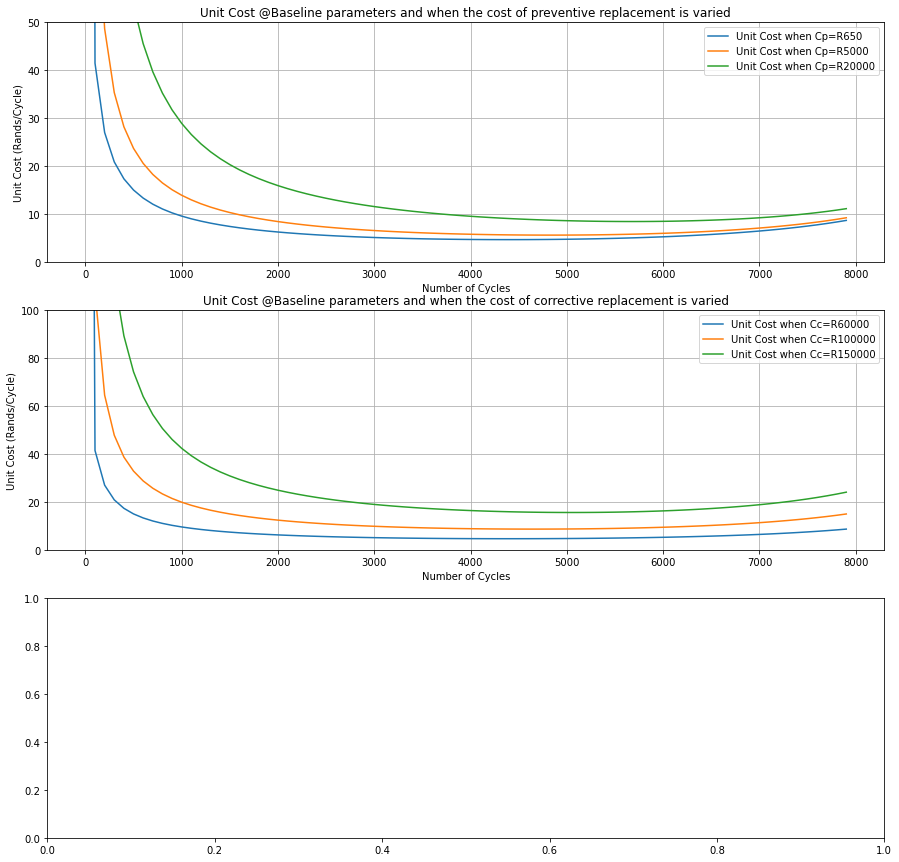

In [42]:
import scipy.integrate as scint
Cc = 60000

Cc1=60000
Cc2=100000
Cc3=150000

Cp1 = 650
Cp2 = 5000
Cp3 = 20000

n_vals1 = np.arange(1, 8000, 100)



tc1 = []
tc2 = []
tc3 = []

def  integrand1(t):
    return t*scistat.norm.pdf(t, loc=mean_c1, scale=std_c1)

def  integrand2(t):
    return t*scistat.norm.pdf(t, loc=mean_c1, scale=std_c1)


def  integrand3(t):
    return t*scistat.norm.pdf(t, loc=mean_c1, scale=std_c1)



for i in range(len(n_vals1)):
    int1, error = scint.quad(integrand1, 0,n_vals1[i])
    tc1.append(int1)

for i in range(len(n_vals1)):
    int2, error1 = scint.quad(integrand2, 0,n_vals1[i])
    tc2.append(int2)

for i in range(len(n_vals1)):
    int3, error2 = scint.quad(integrand3, 0,n_vals1[i])
    tc3.append(int3)

array1=np.array(R_n_vals1)
array2=np.array(R_n_vals2)
array3=np.array(R_n_vals3)
# print(len(tc3))
tc1=np.array(tc1)/(1-array1)
tc2=np.array(tc2)/(1-array1)
tc3=np.array(tc3)/(1-array1)


Le1 = ((n_vals1) * array1) + (tc1) * (1 - array1)
Le2 = ((n_vals1) * array1) + (tc2) * (1 - array1)
Le3 = ((n_vals1) * array1) + (tc3) * (1 - array1)


C1 = Cp1 * array1 + Cc * (1 - array1)
C2 = Cp2 * array1 + Cc * (1 - array1)
C3 = Cp3 * array1 + Cc * (1 - array1)

C4=Cp1 * array1 + Cc1 * (1 - array1)
C5= Cp2 * array1 + Cc2 * (1 - array1)
C6= Cp3 * array1 + Cc3 * (1 - array1)

Cph1 = C1 / Le1
Cph2 = C2 / Le2
Cph3 = C3 / Le3

Cph4 = C4 / Le1
Cph5 = C5 / Le2
Cph6 = C6 / Le3


idx_min = np.argmin(Cph1)
xmin1 = n_vals1[idx_min]
ymin1 = np.nanmin(Cph1)
print('Optimal Replacement Cycle when Cp=R650',xmin1,'Cycles')
print('Optimal Replacement Cost when Cp=R650',ymin1,'Rands/Cycle')


idx_min1 = np.argmin(Cph2)
xmin2 = n_vals2[idx_min1]
ymin2 = np.nanmin(Cph2)
print('Optimal Replacement Cycle when Cp=R5000',xmin2,'Cycles')
print('Optimal Replacement Cost when Cp=R5000',ymin2,'Rands/Cycle')

idx_min2 = np.argmin(Cph3)
xmin3 = n_vals3[idx_min2]
ymin3 = np.nanmin(Cph3)
print('Optimal Replacement Cycle when Cp=R20000',xmin3,'Cycles')
print('Optimal Replacement Cost when Cp=R20000',ymin3,'Rands/Cycle')


idx_min4 = np.argmin(Cph4)
xmin4 = n_vals1[idx_min4]
ymin4 = np.nanmin(Cph4)
print('Optimal Replacement Cycle when Cc=R60000',xmin4,'Cycles')
print('Optimal Replacement Cost when Cc=R60000',ymin4,'Rands/Cycle')


idx_min5 = np.argmin(Cph5)
xmin5 = n_vals2[idx_min5]
ymin5 = np.nanmin(Cph5)
print('Optimal Replacement Cycle when Cc=R100000',xmin5,'Cycles')
print('Optimal Replacement Cost when Cc=R100000',ymin5,'Rands/Cycle')

idx_min6 = np.argmin(Cph6)
xmin6 = n_vals3[idx_min6]
ymin6 = np.nanmin(Cph6)
print('Optimal Replacement Cycle when Cc=R150000',xmin6,'Cycles')
print('Optimal Replacement Cost when Cc=R150000',ymin6,'Rands/Cycle')

x1=ymin1*1.15
x2=ymin2*1.15
x3=ymin3*1.15


indices_within_5_percent1 = np.where((Cph1 >= ymin1) & (Cph1 <= x1))[0]
indices_within_5_percent2 = np.where((Cph2 >= ymin2) & (Cph2 <= x2))[0]
indices_within_5_percent3 = np.where((Cph3 >= ymin3) & (Cph3 <= x3))[0]

print("15% Time Interval:", [n_vals1[indices_within_5_percent1[0]], n_vals1[indices_within_5_percent1[-1]]])
print("15% Time Interval:", [n_vals2[indices_within_5_percent2[0]], n_vals2[indices_within_5_percent2[-1]]])
print("15% Time Interval:", [n_vals3[indices_within_5_percent3[0]], n_vals3[indices_within_5_percent3[-1]]])

print("Cost per Day @ 15% Time Interval:", [Cph1[indices_within_5_percent1[0]], Cph1[indices_within_5_percent1[-1]]])
print("Cost per Day @ 15% Time Interval:", [Cph2[indices_within_5_percent2[0]], Cph2[indices_within_5_percent2[-1]]])
print("Cost per Day @ 15% Time Interval:", [Cph3[indices_within_5_percent3[0]], Cph3[indices_within_5_percent3[-1]]])
# # Cph_c=C2/Le
# # Cph_c=C2/Le
fig, ax = plt.subplots(3, 1, figsize=(15, 15))

ax[0].set_title('Unit Cost @Baseline parameters and when the cost of preventive replacement is varied')
ax[0].plot(n_vals1, Cph1, label='Unit Cost when Cp=R650')
ax[0].plot(n_vals1, Cph2, label='Unit Cost when Cp=R5000')
ax[0].plot(n_vals1, Cph3, label='Unit Cost when Cp=R20000')
# ax[0].plot(xmin, ymin, 'o')
# ax[0].plot(xmin1, ymin1, 'o')
# ax[0].plot(xmin2, ymin2, 'o')
# ax[0].plot(tp[indices_within_5_percent1[0]], Cph1[indices_within_5_percent1[0]], 's', color='green', markersize=8, label='5% Increase Start')
# ax[0].plot(tp[indices_within_5_percent1[-1]], Cph1[indices_within_5_percent1[-1]], 's', color='green', markersize=8, label='5% Increase End')

ax[0].set_xlabel('Number of Cycles')
ax[0].set_ylabel('Unit Cost (Rands/Cycle)')
ax[0].legend()
ax[0].set_ylim(0,50)
ax[0].grid(True)

ax[1].set_title('Unit Cost @Baseline parameters and when the cost of corrective replacement is varied')
ax[1].plot(n_vals1, Cph4, label='Unit Cost when Cc=R60000')
ax[1].plot(n_vals1, Cph5, label='Unit Cost when Cc=R100000')
ax[1].plot(n_vals1, Cph6, label='Unit Cost when Cc=R150000')
# ax[1].plot(xmin1, ymin1, 'o')
# ax[1].plot(tp[indices_within_5_percent2[0]], Cph2[indices_within_5_percent2[0]], 's', color='red', markersize=8, label='5% Increase Start')
# ax[1].plot(tp[indices_within_5_percent2[-1]], Cph2[indices_within_5_percent2[-1]], 's', color='red', markersize=8, label='5% Increase End')

ax[1].set_xlabel('Number of Cycles')
ax[1].set_ylabel('Unit Cost (Rands/Cycle)')
ax[1].set_ylim(0,100)
ax[1].legend()
ax[1].grid(True)

# ax[2].set_title('Unit Cost @Baseline parameters and n=15000')
# ax[2].plot(n_vals1, Cph3, label='Unit Cost when n=15000')
# ax[2].plot(xmin2, ymin2, 'o')
# ax[2].plot(tp[indices_within_5_percent3[0]], Cph3[indices_within_5_percent3[0]], 's', color='yellow', markersize=8, label='5% Increase Start')
# ax[2].plot(tp[indices_within_5_percent3[-1]], Cph3[indices_within_5_percent3[-1]], 's', color='yellow', markersize=8, label='5% Increase End')

# ax[2].set_xlabel('Number of Cycles')
# ax[2].set_ylabel('Unit Cost (Rands/Cycle)')
# ax[2].legend()
# ax[2].set_ylim(0,200)
# ax[2].grid(True)